S&P 500 — фондовый индекс, в корзину которого включено 505 акций 500 избранных торгуемых на фондовых биржах США

In [2]:
import pandas as pd
import statsmodels.graphics.tsaplots as sgt

data = pd.read_csv('./sp500.csv', parse_dates=["Date"], index_col = ["Date"])
data.head()

,spx
Date,
1994-01-06,467.119995
1994-01-07,469.899994
1994-01-10,475.269989
1994-01-11,474.130005
1994-01-12,474.170013


<AxesSubplot:xlabel='Date'>

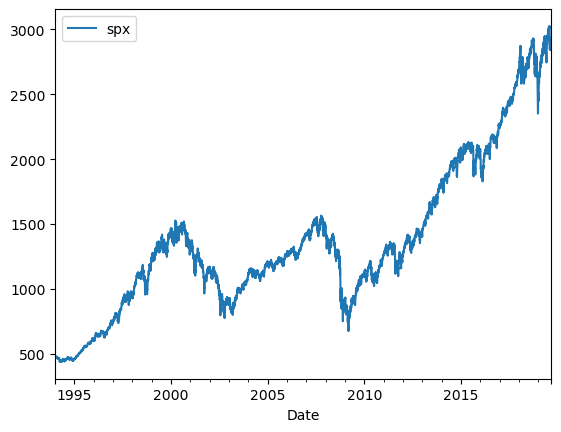

In [3]:
%matplotlib inline 
data.plot()

In [4]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((6518, 1), (174, 1))

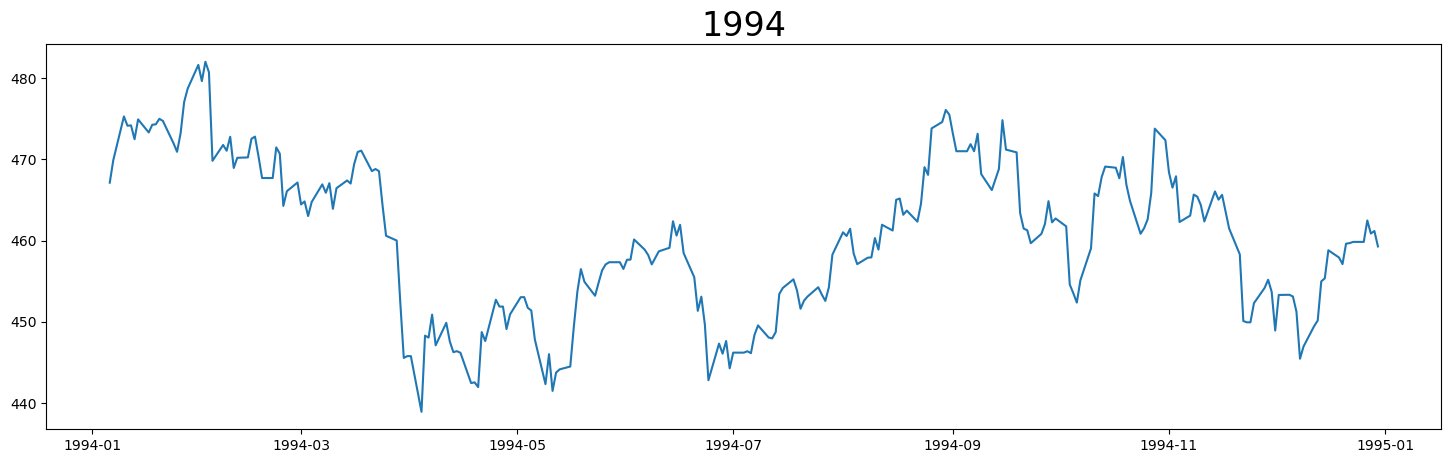

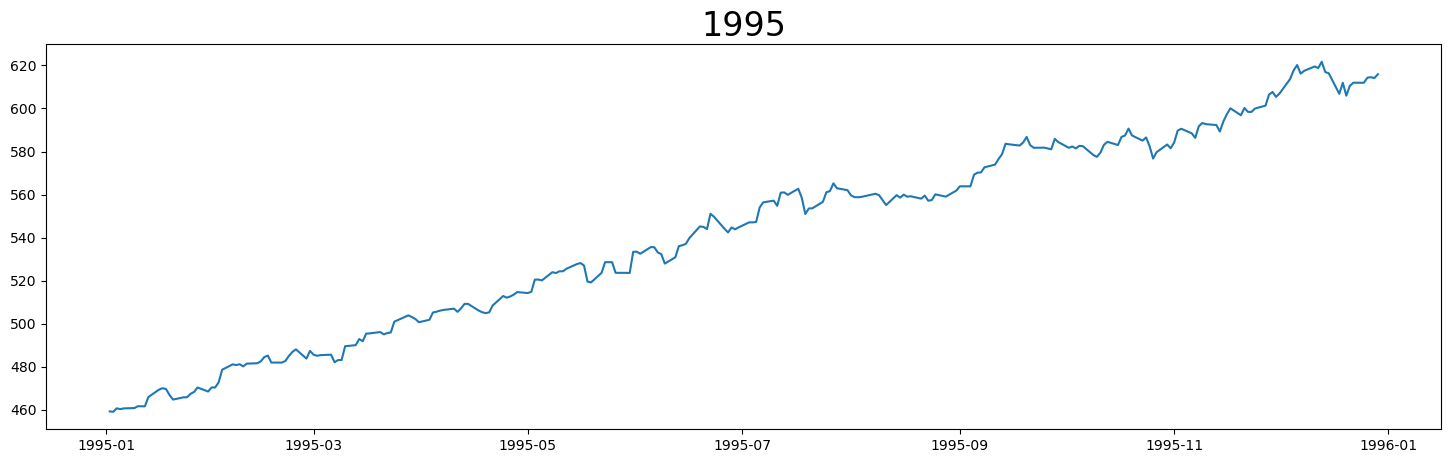

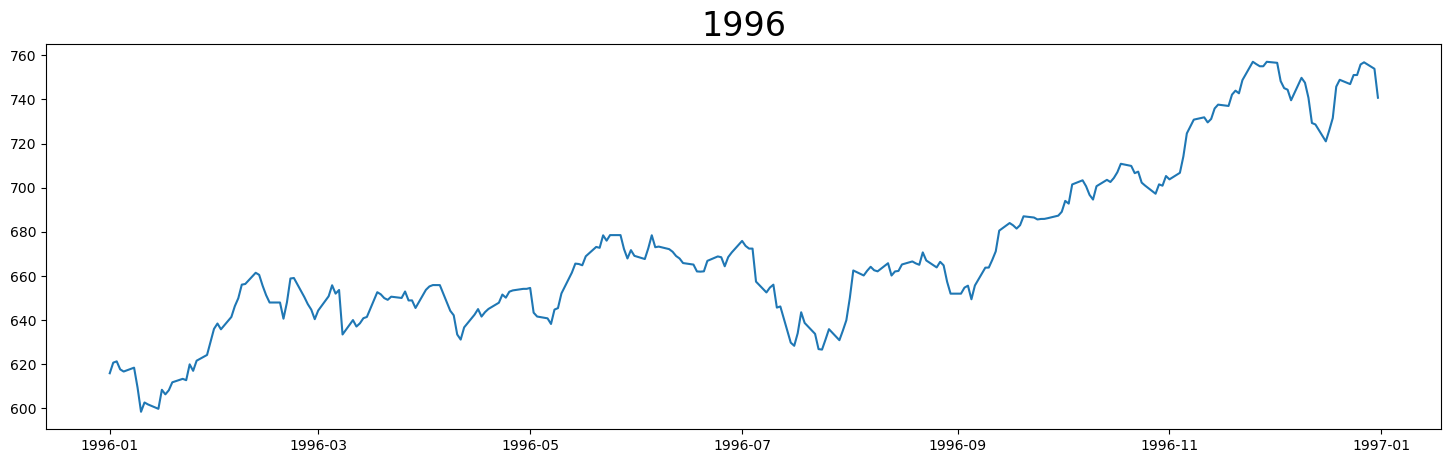

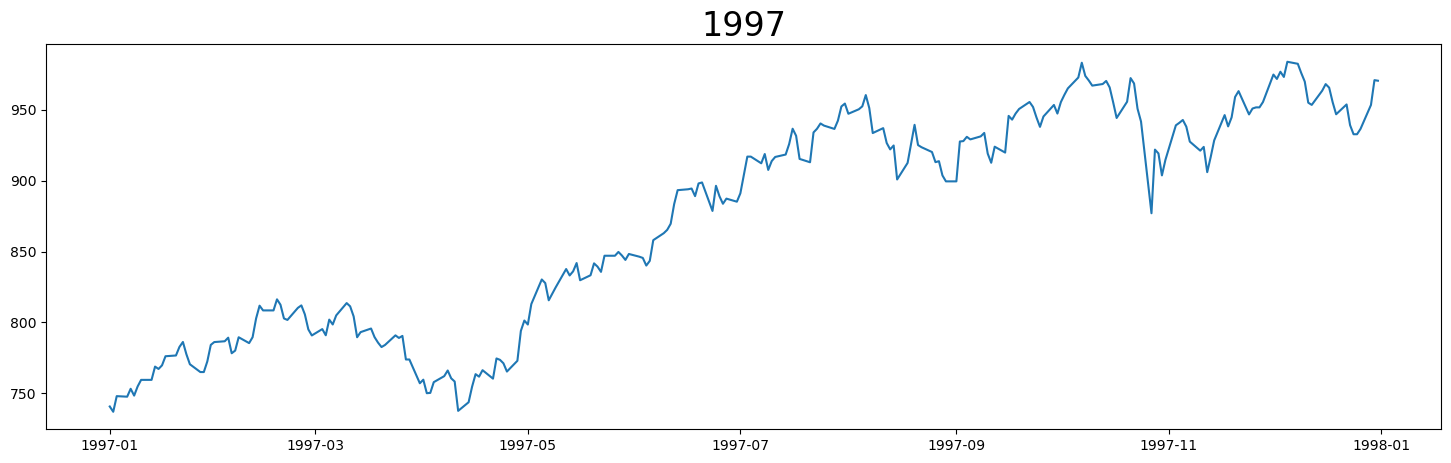

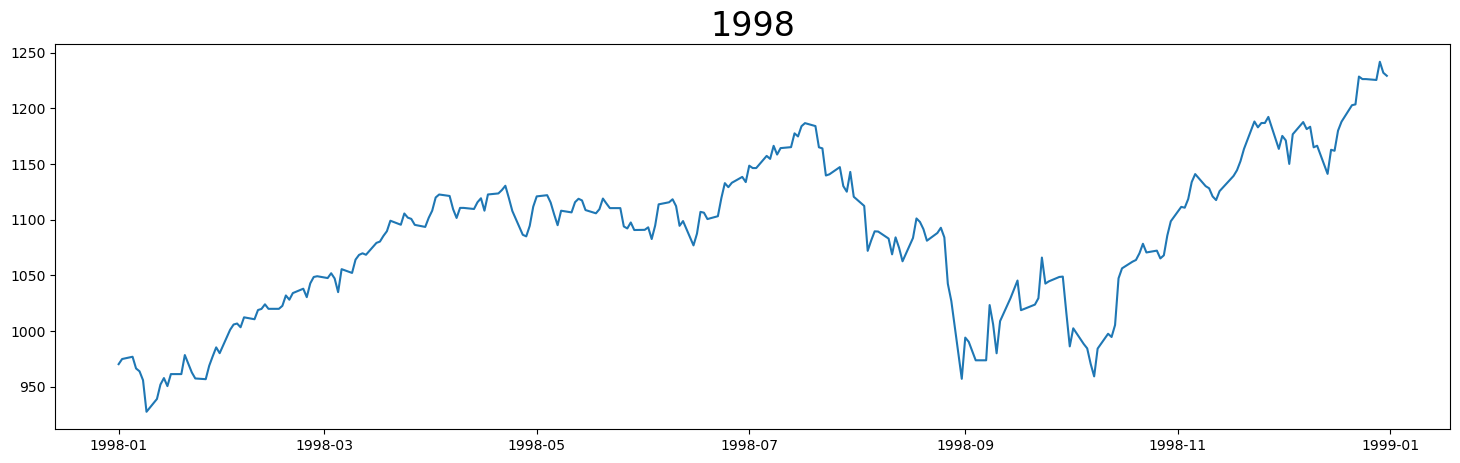

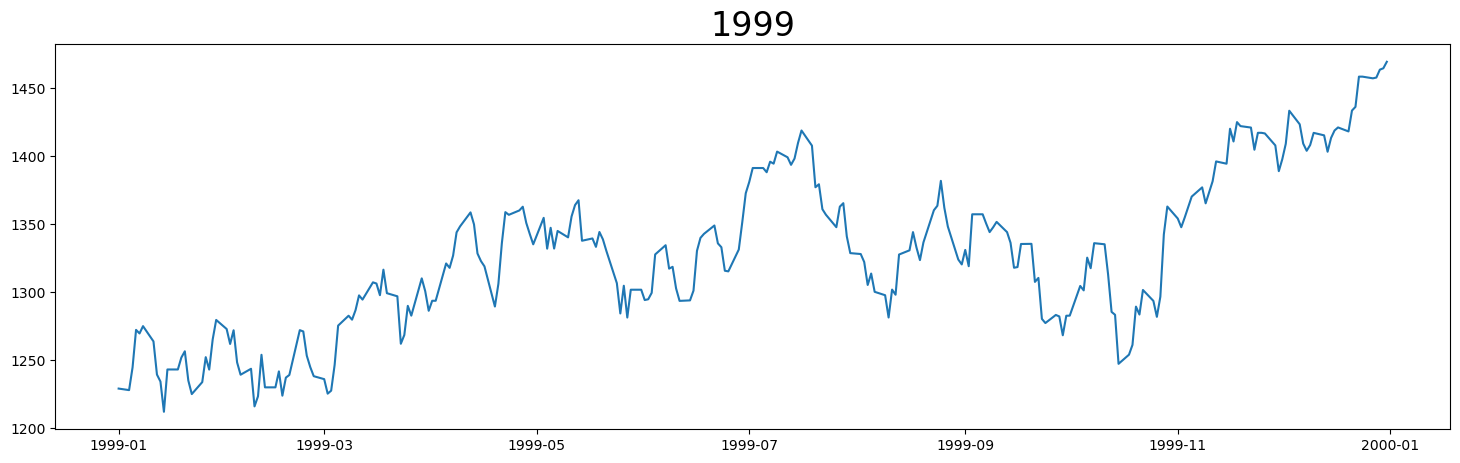

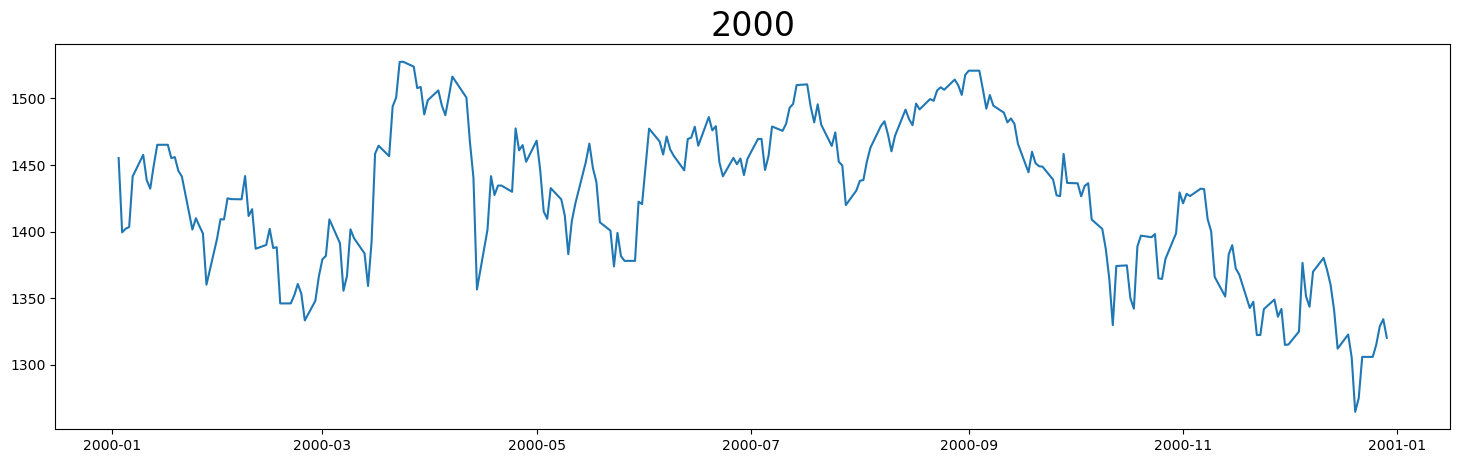

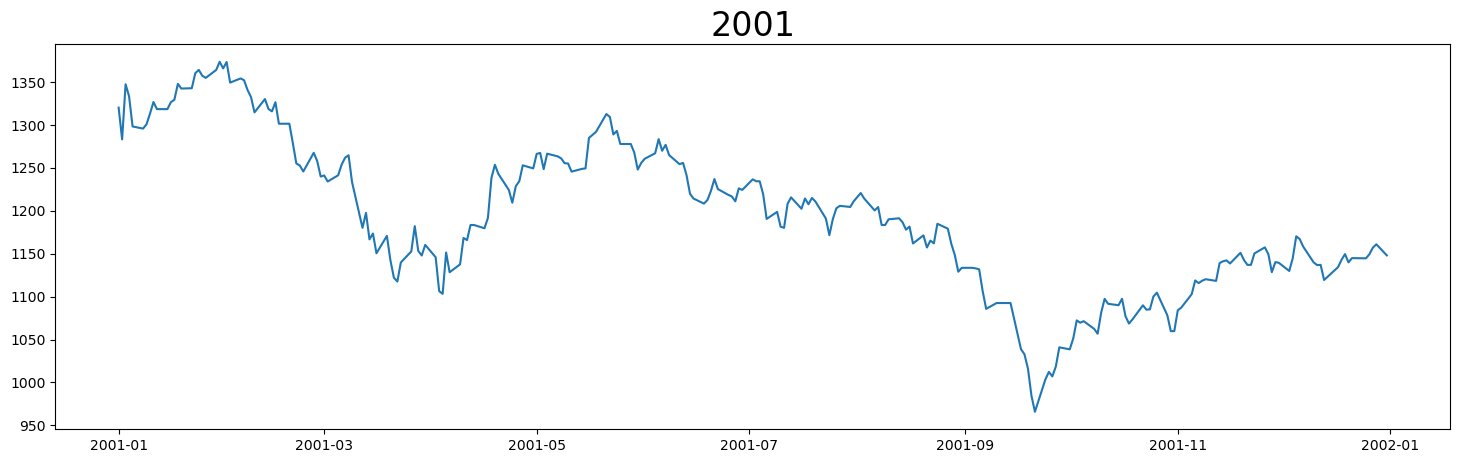

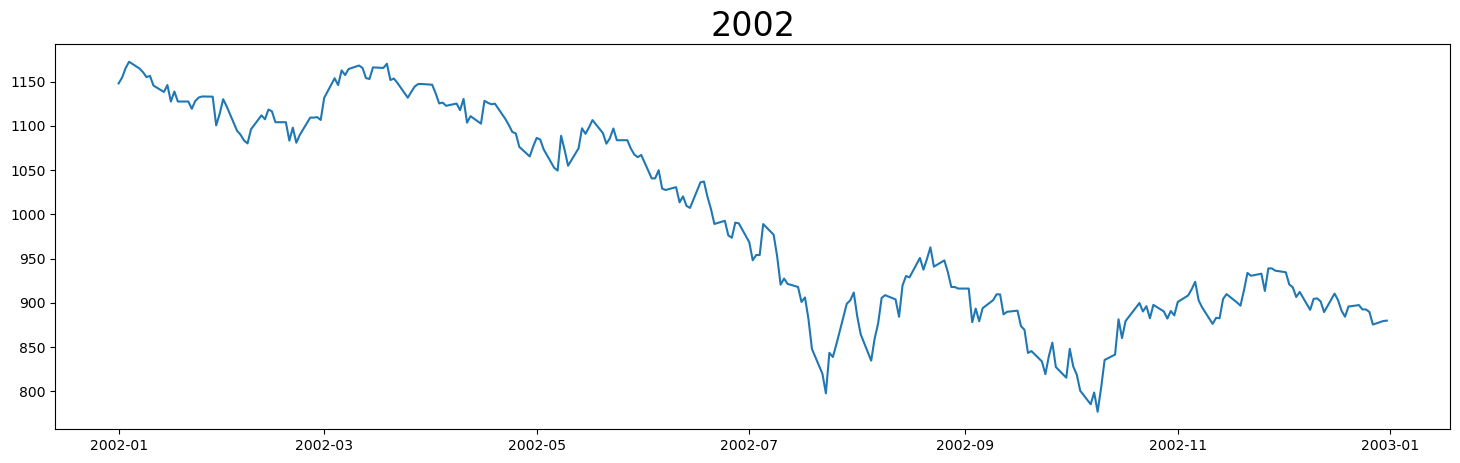

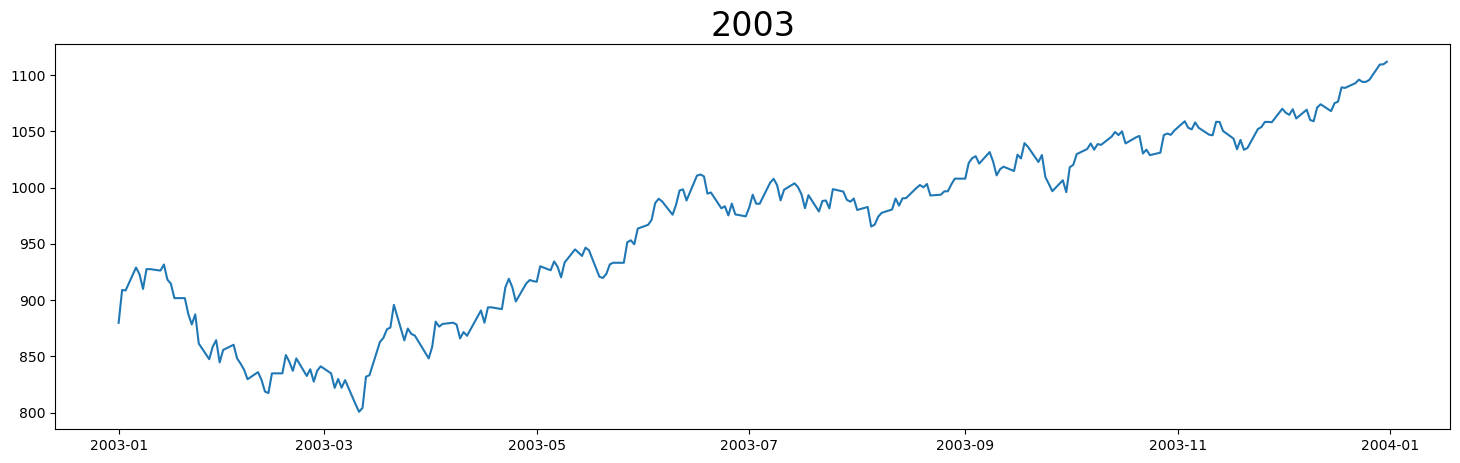

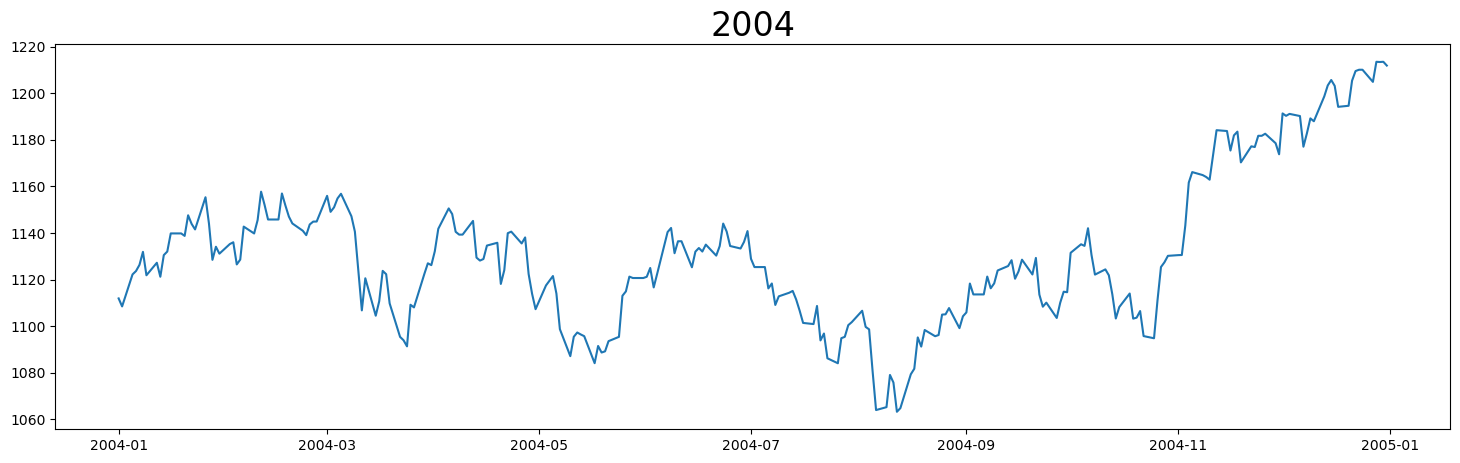

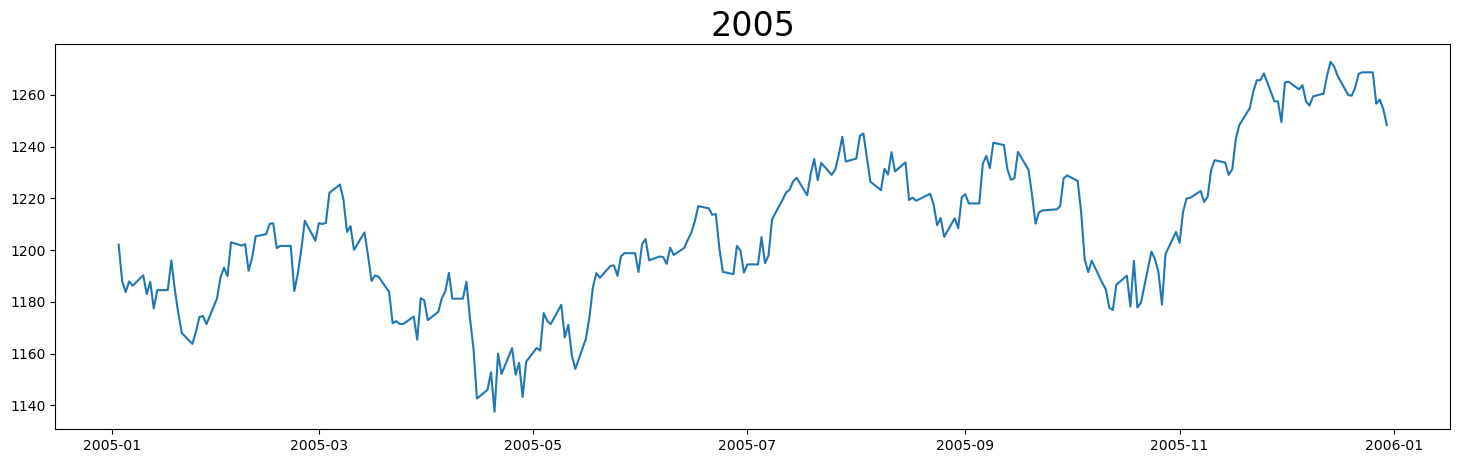

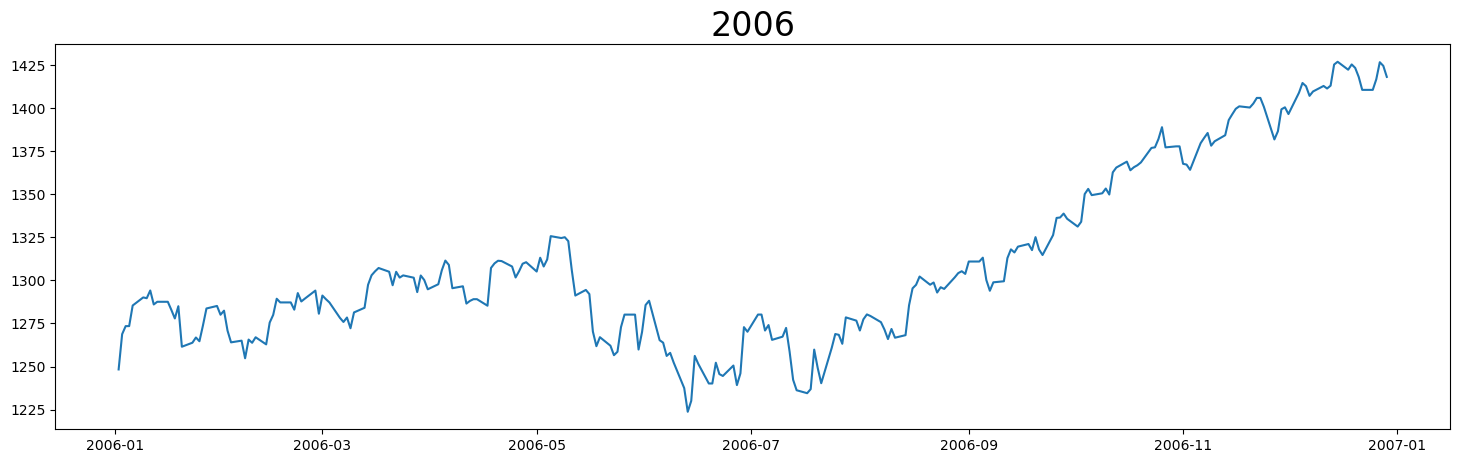

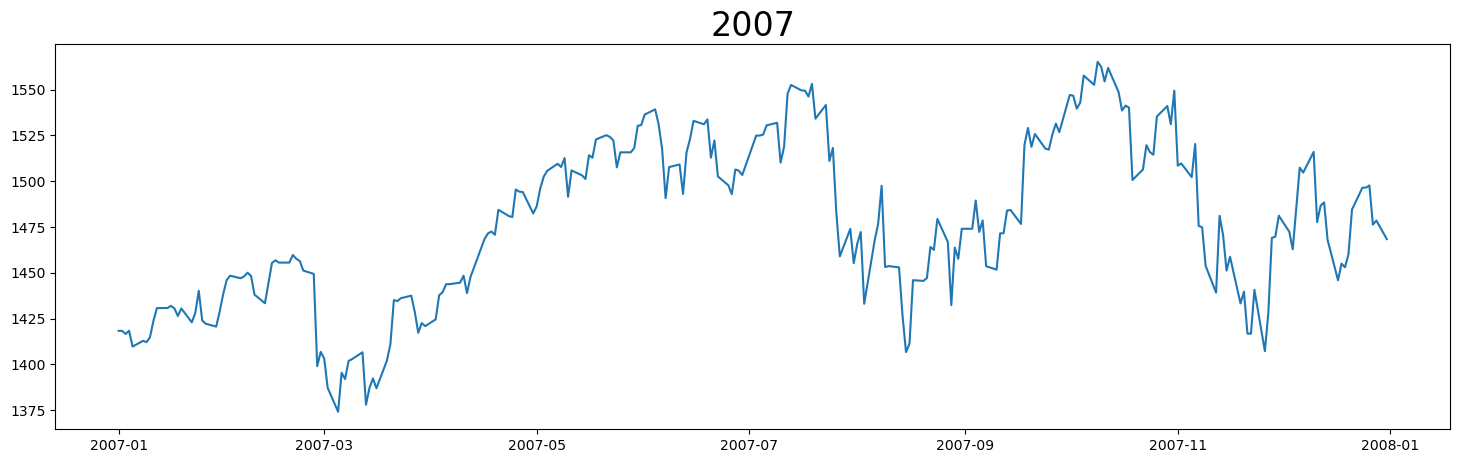

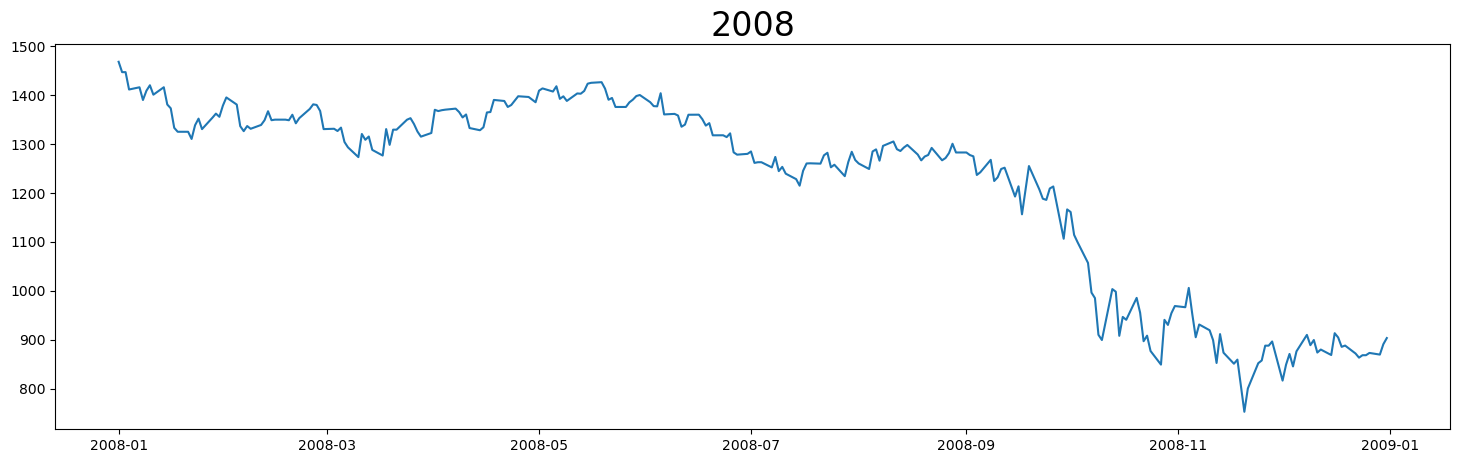

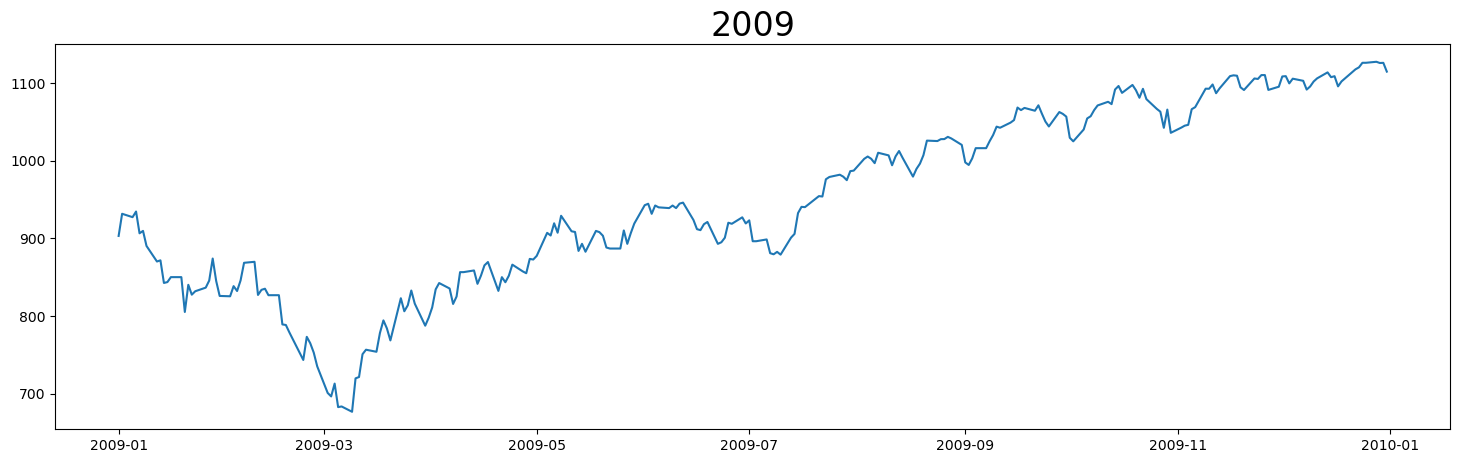

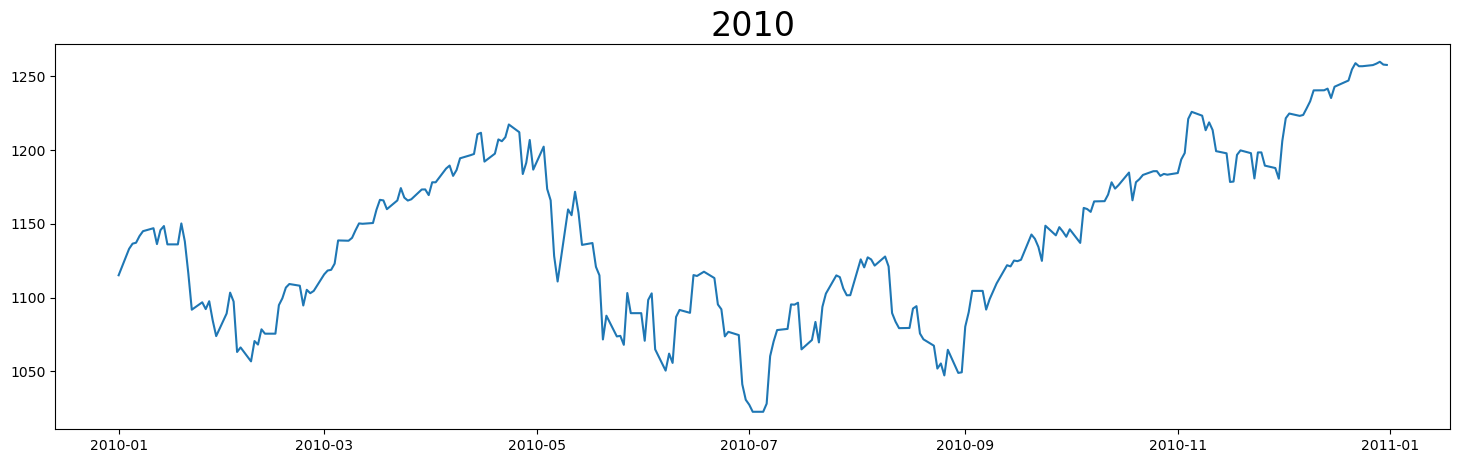

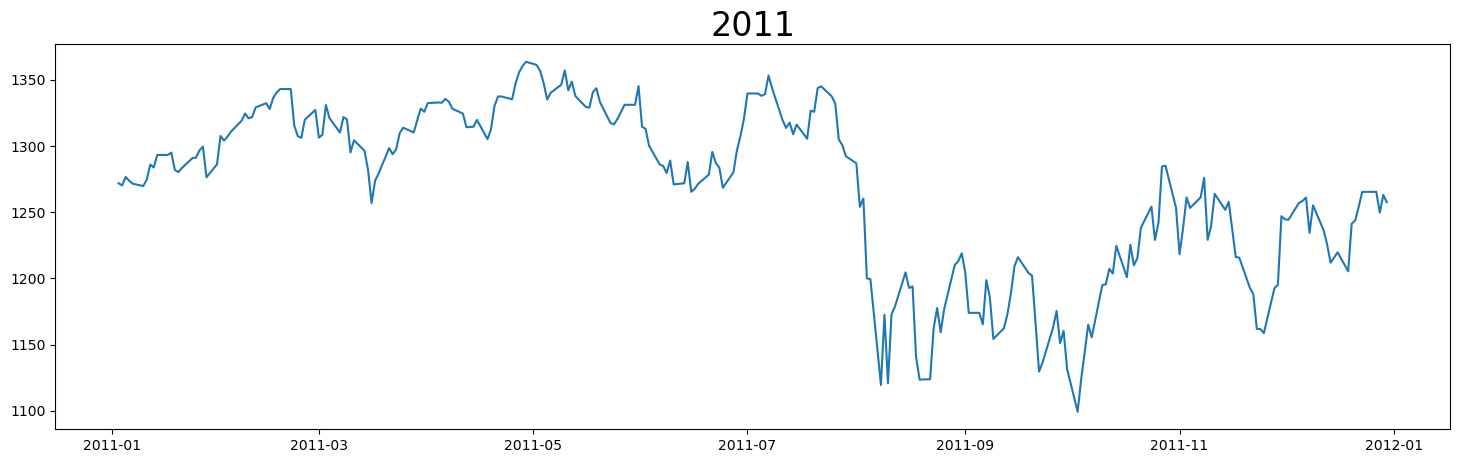

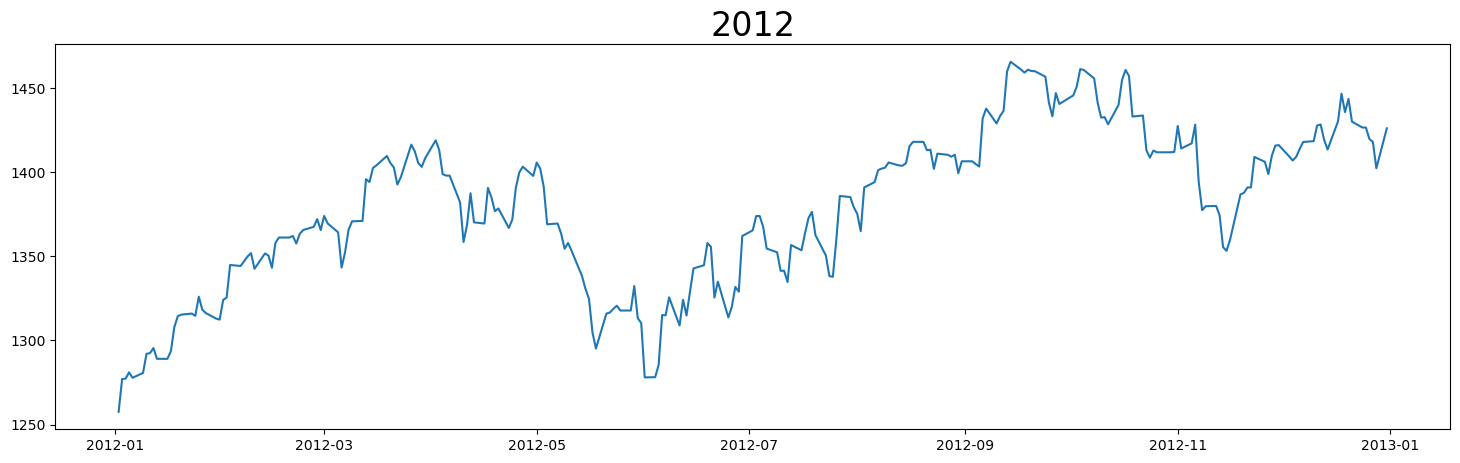

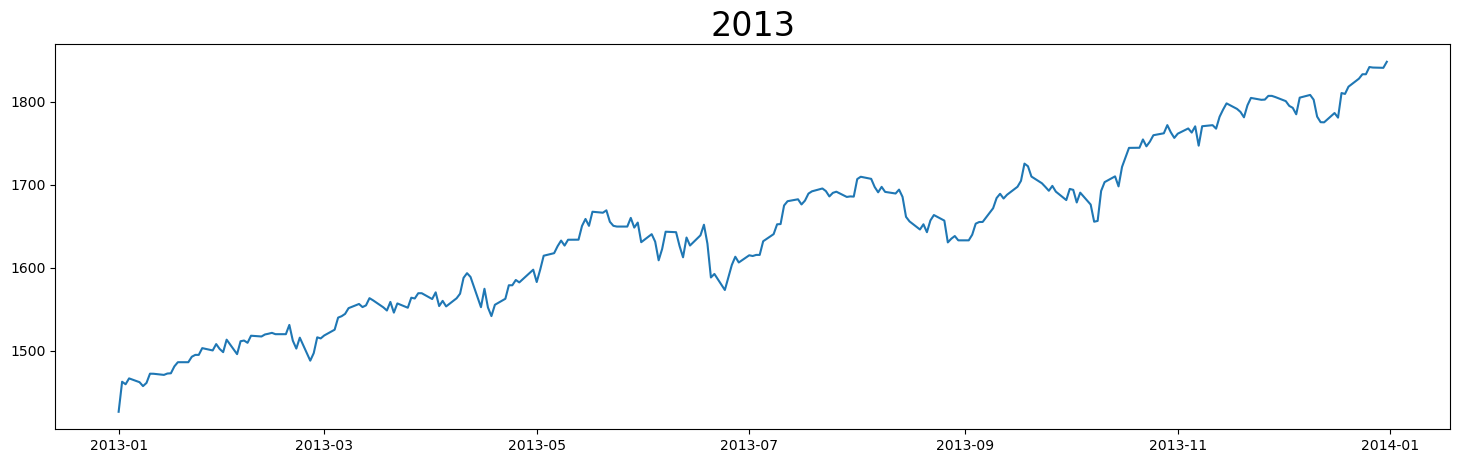

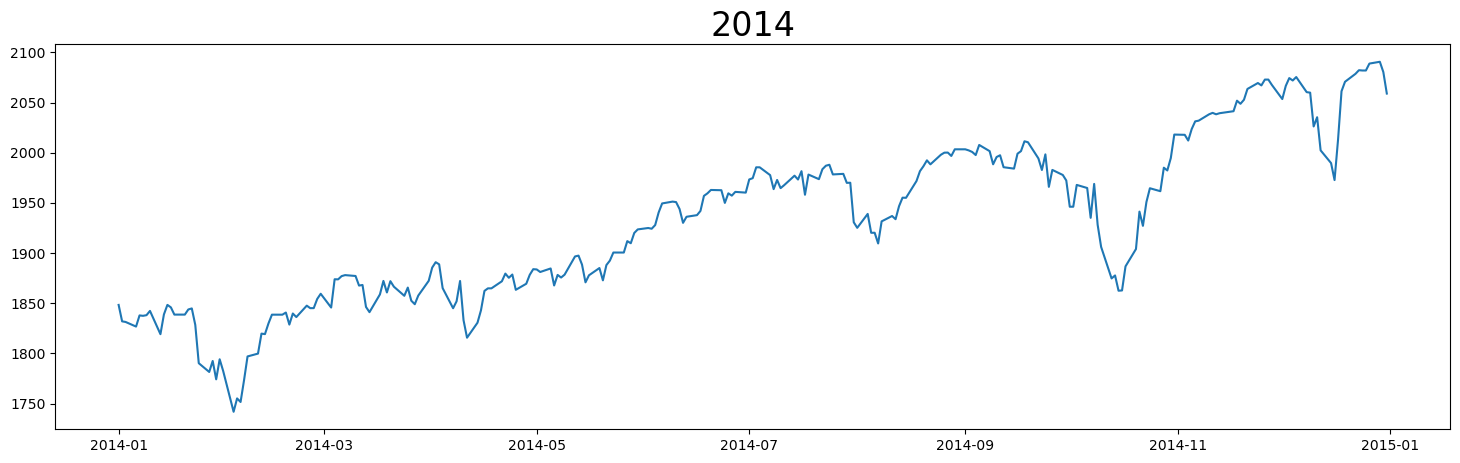

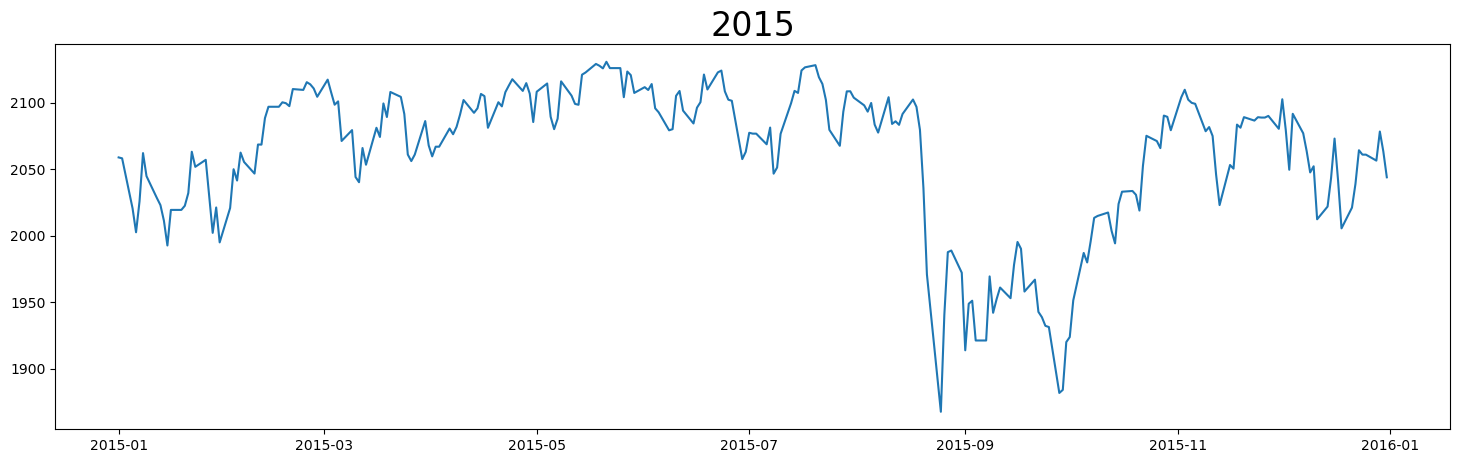

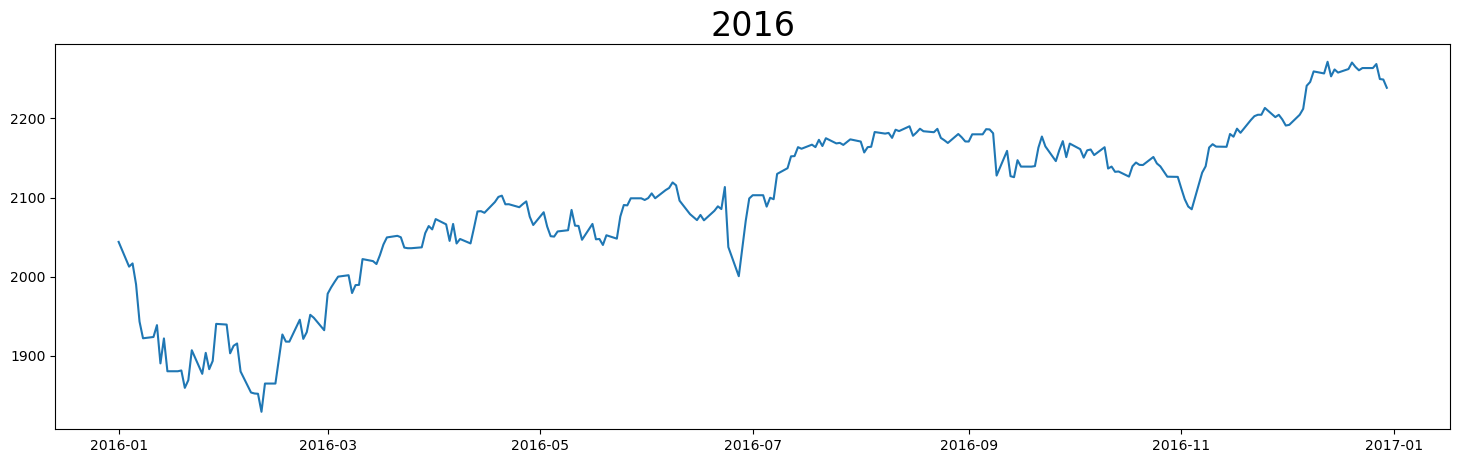

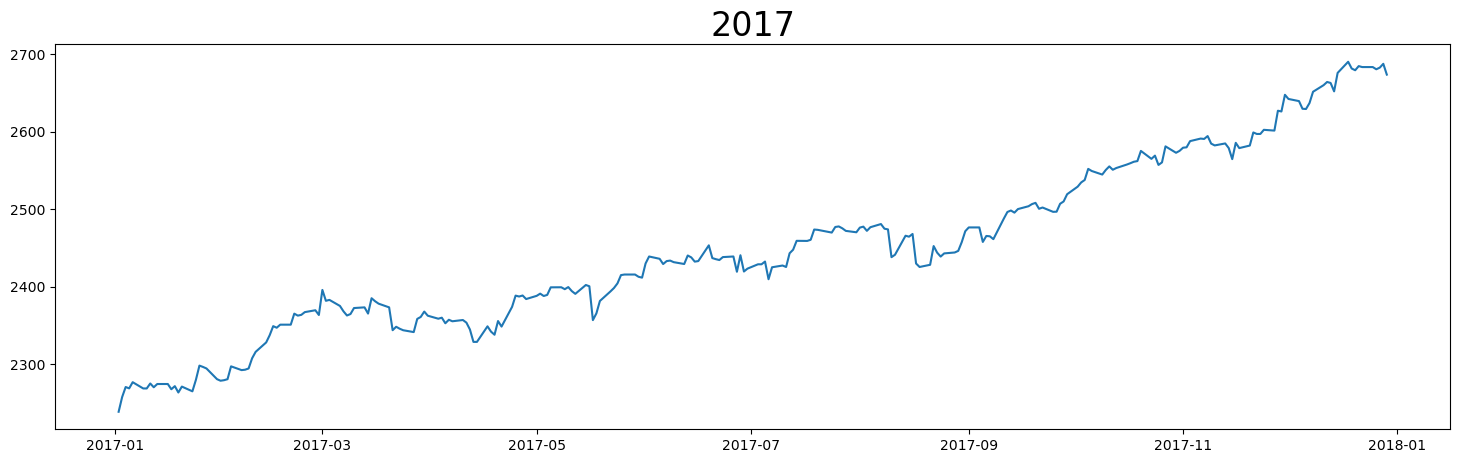

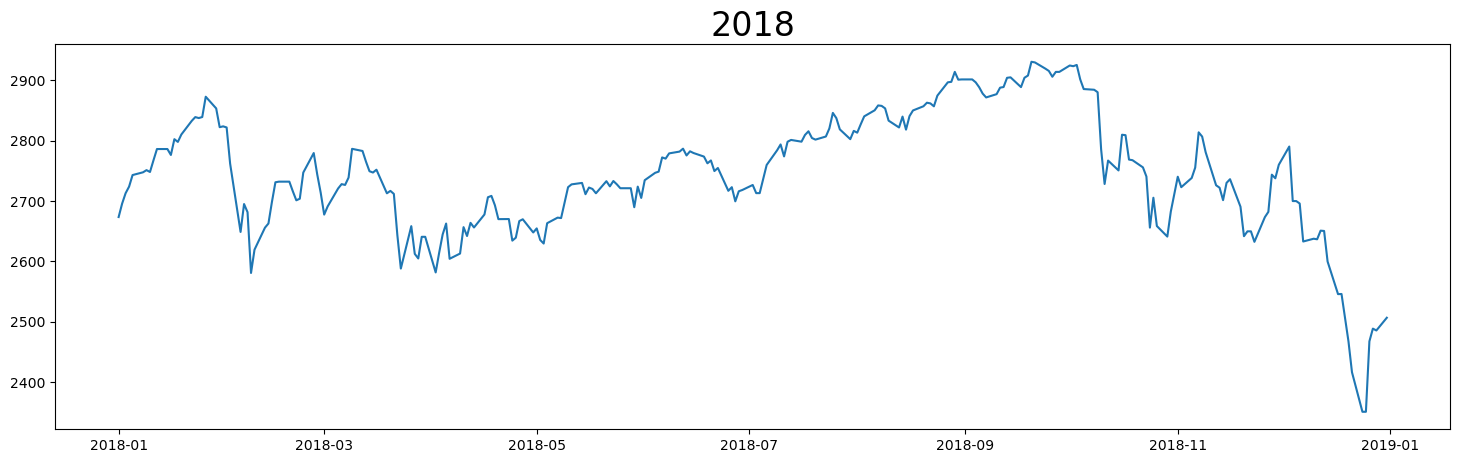

In [5]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = 18, 5

for year in set(train_df.index.year):
    plt.plot(train_df[["spx"]].loc[train_df.index.year == year])
    plt.title(str(year), size = 24)
    plt.show()

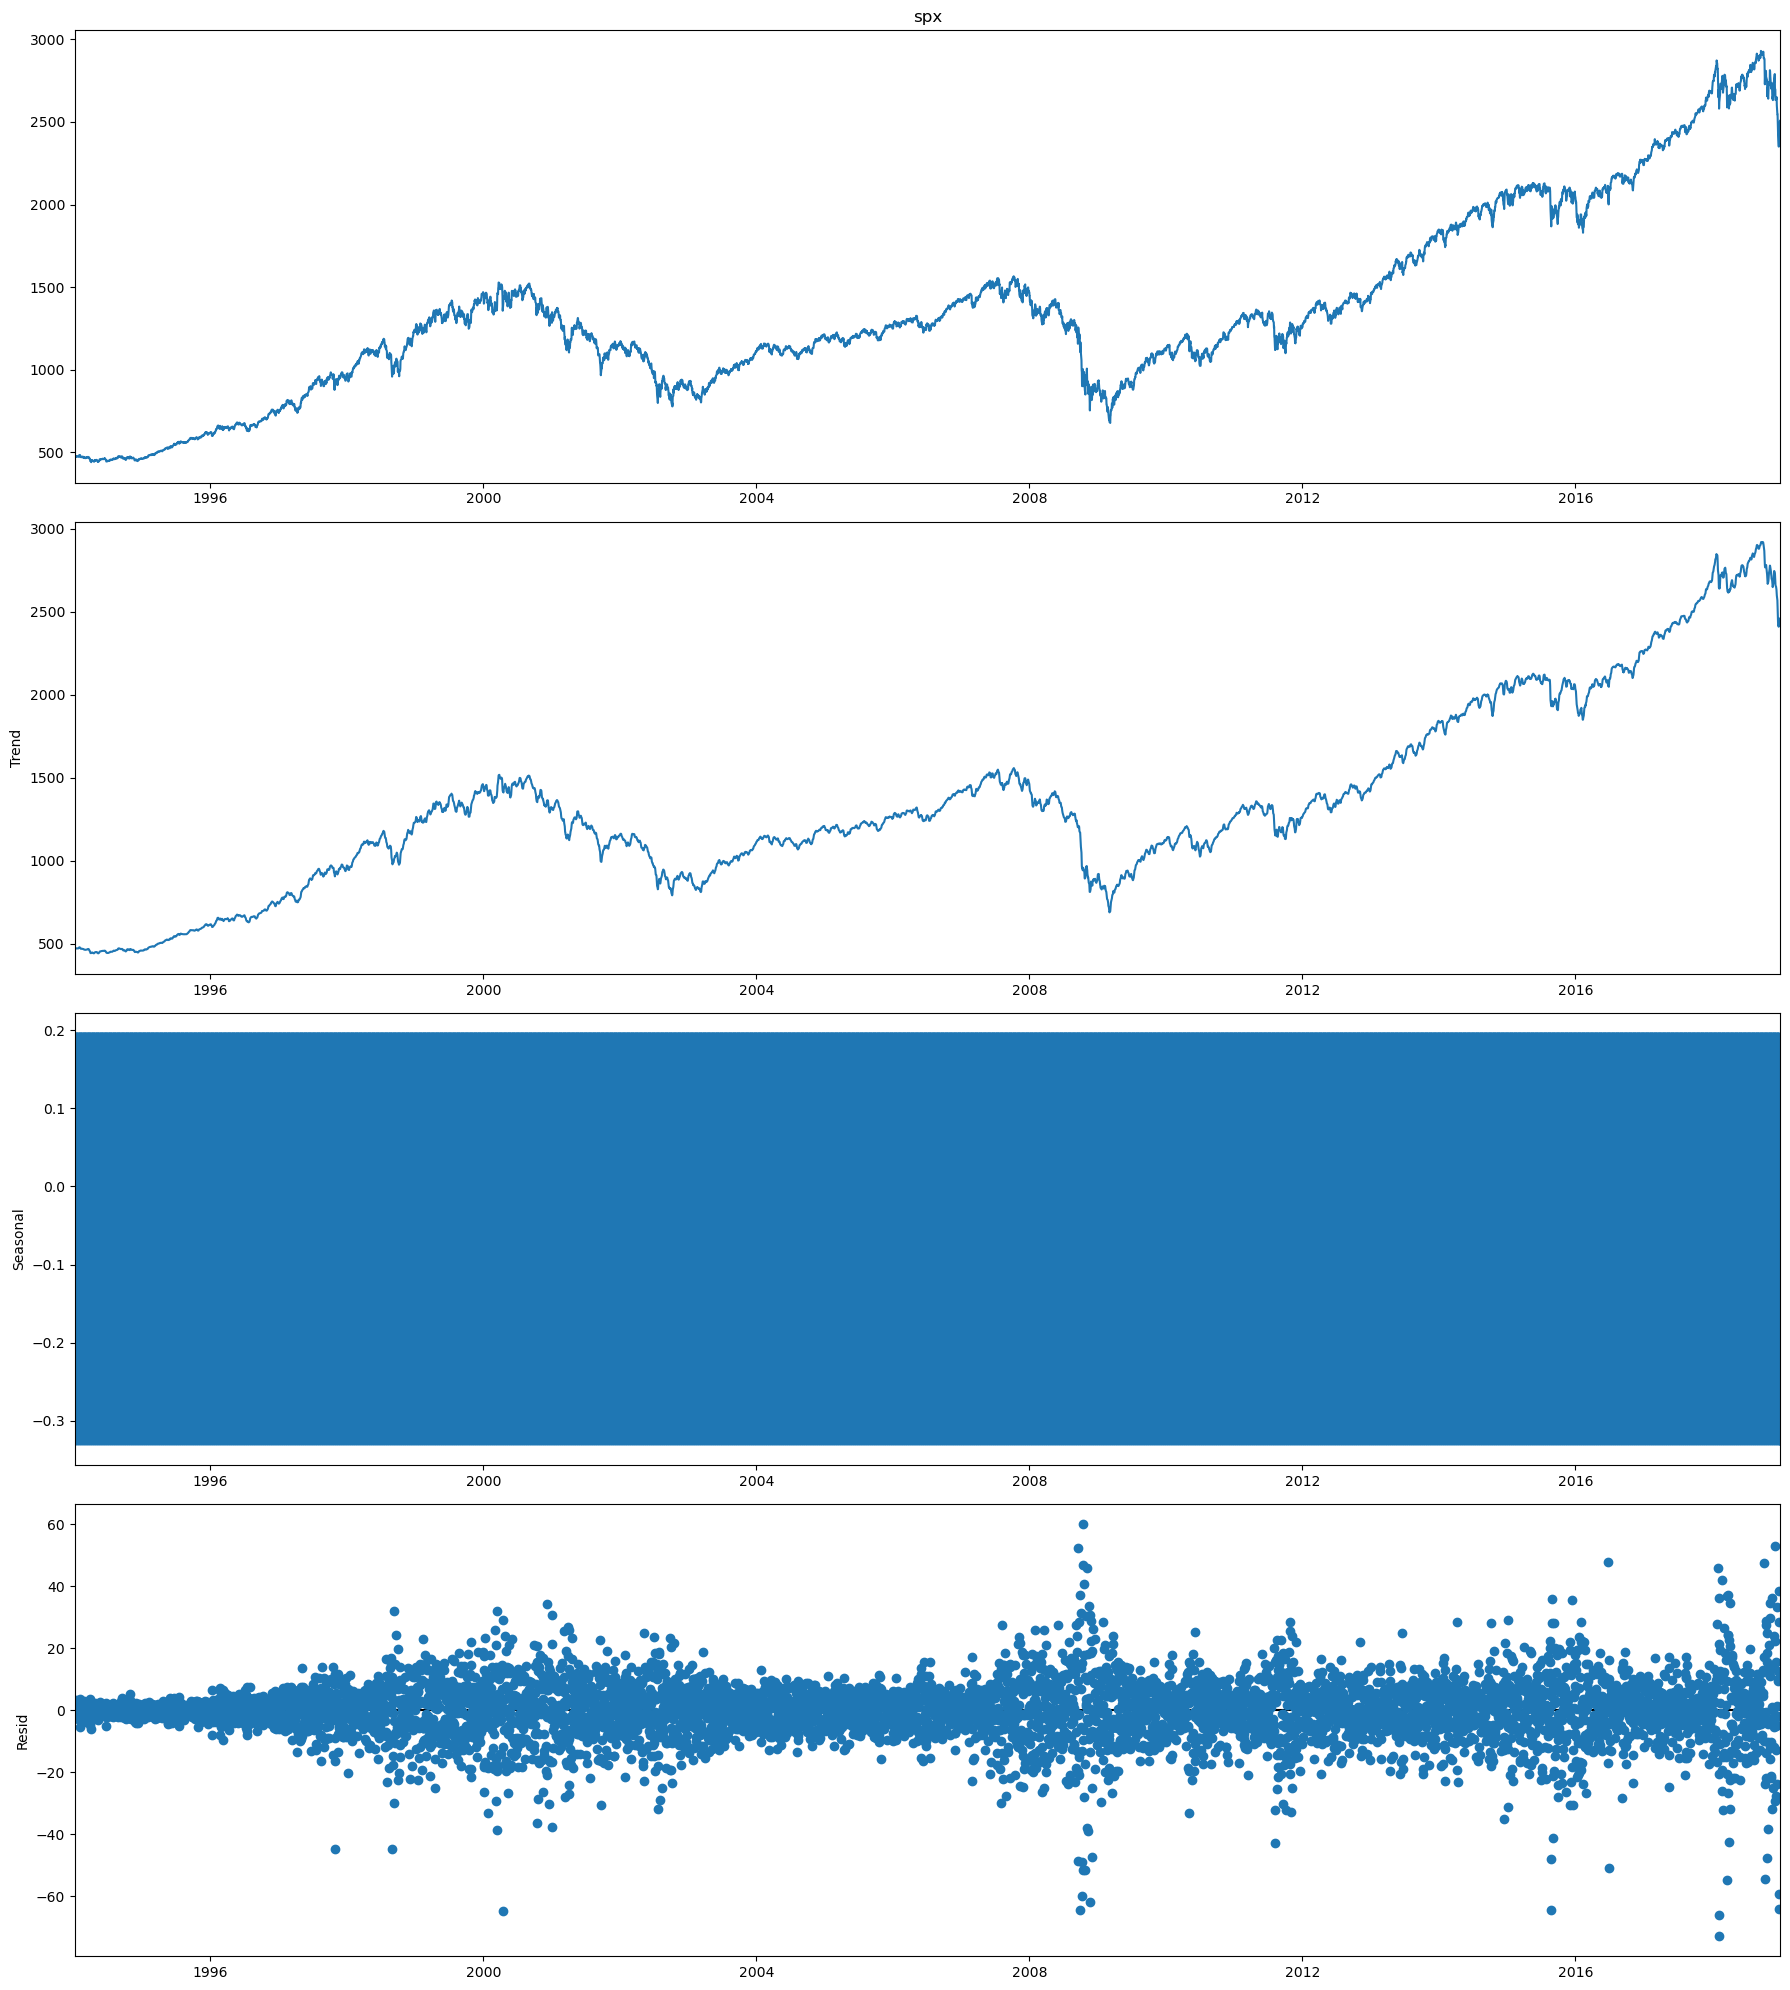

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df.spx, model='additive')
result.plot()
plt.show()

Сезонная компонента выглядит очень странно, посмотрим на первые 20 значений

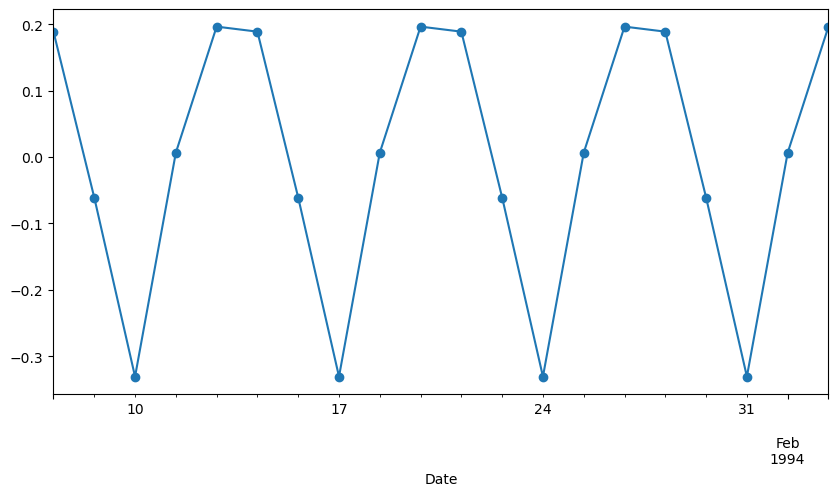

In [7]:
plt.rcParams["figure.figsize"] = 10, 5
result.seasonal[:20].plot(marker = "o")
plt.show()

График четко показывает повторяющийся цикл каждые 5 периодов. Это довольно логично, поскольку наши данные — это данные о ценах на акции. Мы наблюдаем и собираем данные о ценах на акции каждый рабочий день недели. Это означает, что данные представляли собой еженедельную сезонность, а неделя была рабочей неделей (5 дней в неделю)

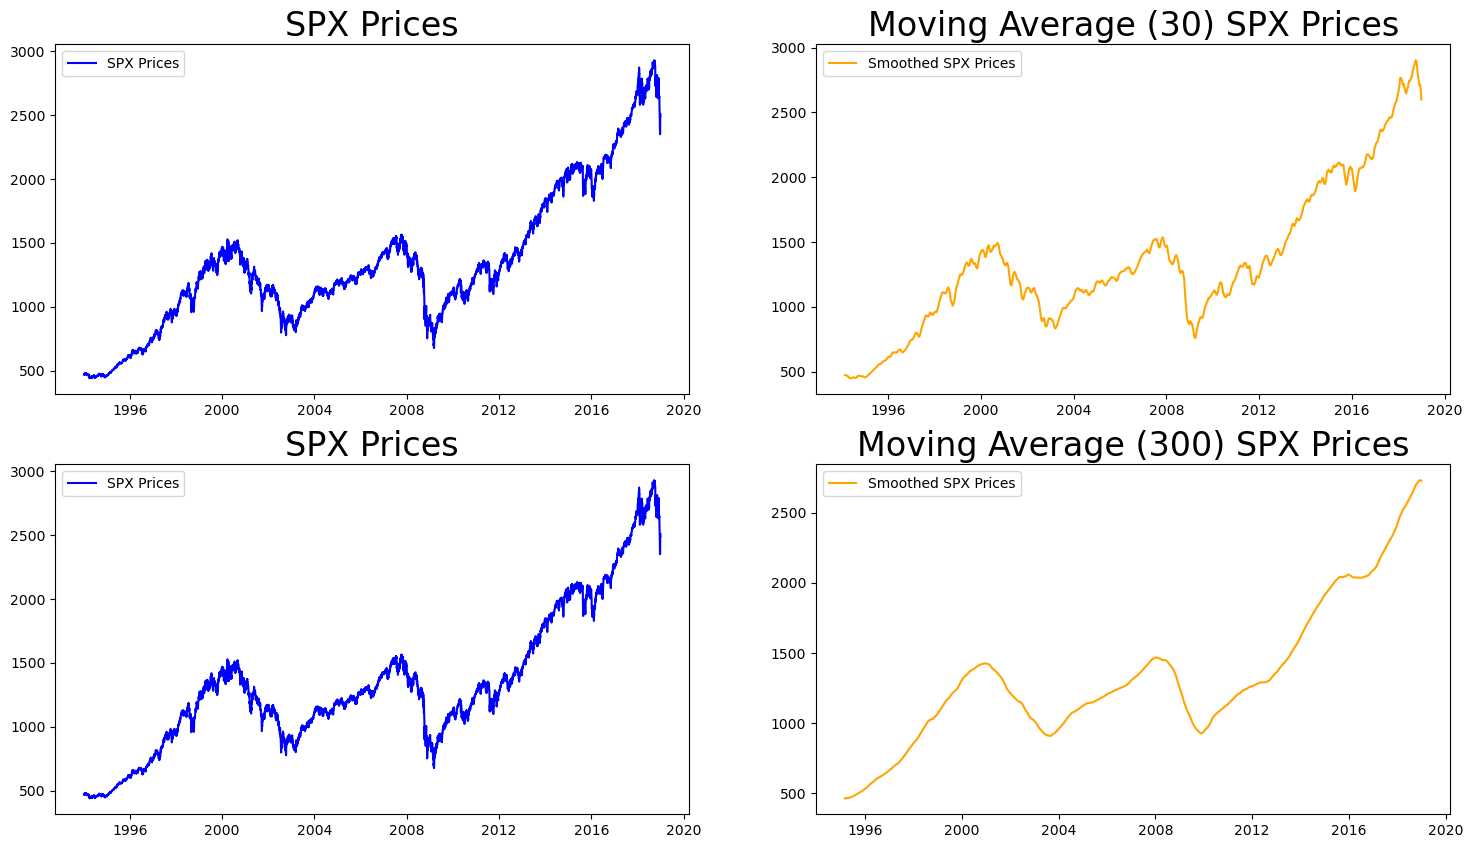

In [8]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в месяц (Window = 30) 
ax[0, 0].plot(train_df.spx, color = "blue", label = "SPX Prices")
ax[0, 0].set_title("SPX Prices", size = 24)
ax[0, 0].legend()

ax[0, 1].plot(train_df.spx.rolling(window=30).mean(), color = "orange", label = "Smoothed SPX Prices")
ax[0, 1].set_title("Moving Average (30) SPX Prices", size = 24)
ax[0, 1].legend()


# Окно в год (Window = 300)
ax[1, 0].plot(train_df.spx, color = "blue", label = "SPX Prices")
ax[1, 0].set_title("SPX Prices", size = 24)
ax[1, 0].legend()

ax[1, 1].plot(train_df.spx.rolling(window=300).mean(), color = "orange", label = "Smoothed SPX Prices")
ax[1, 1].set_title("Moving Average (300) SPX Prices", size = 24)
ax[1, 1].legend()

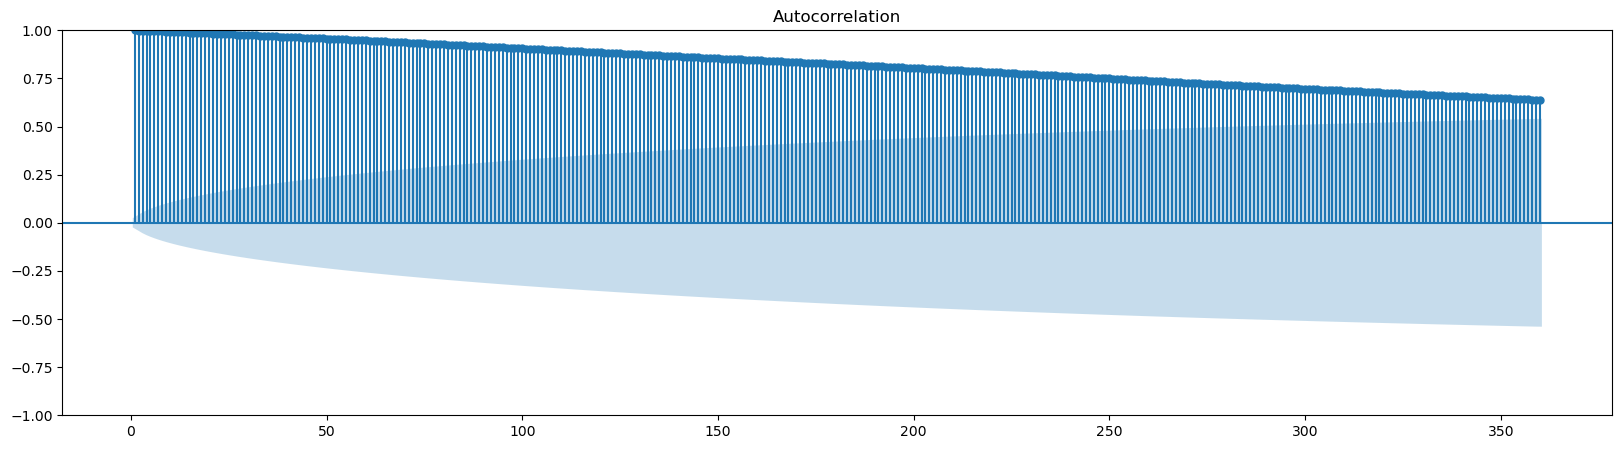

In [9]:
import statsmodels.graphics.tsaplots as sgt
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df.spx, zero = False, lags = 360)
plt.show()

цены SPX сильно коррелированы. Корреляция сохраняется даже по прошествии года.

/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


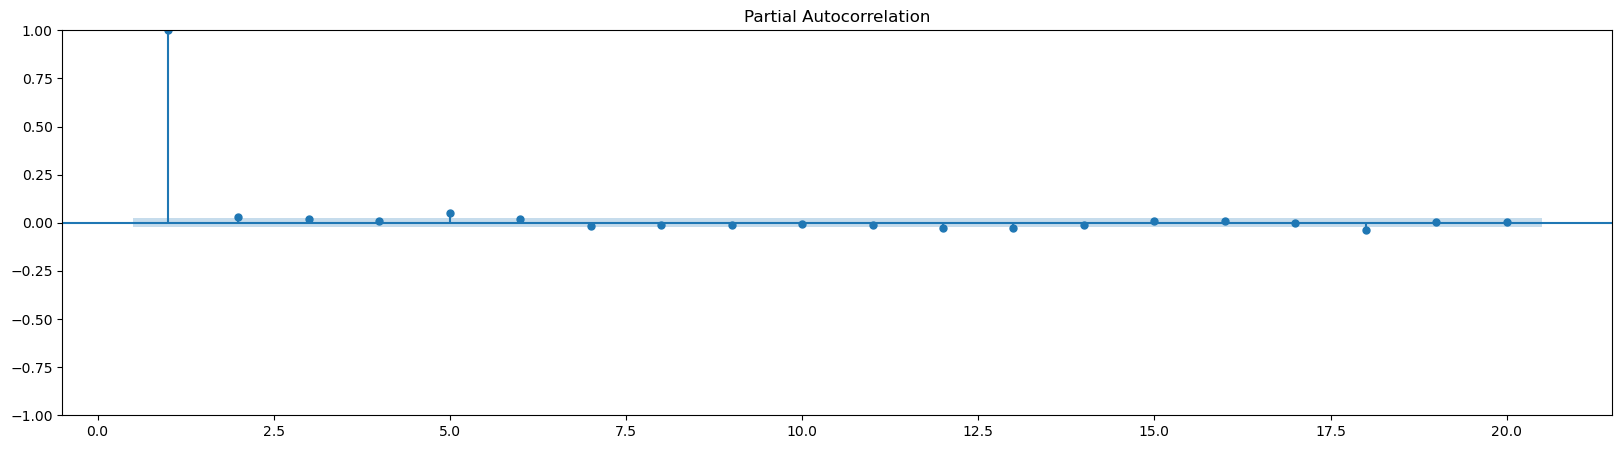

In [10]:
import statsmodels.graphics.tsaplots as sgt
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df.spx, zero = False, lags = 20)
plt.show()

Эти графики показывают, как данные коррелируют с запаздывающей версией самих себя.
В отличие от того, что предлагали графики ACF, цены SPX с лагом не приносят никакой новой информации. В таких ситуация параметр p выбирается =1


In [11]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df["spx"])

(-0.331280939696526,
 0.9209556878912155,
 10,
 6507,
 {'1%': -3.4313553606207843,
  '5%': -2.8619842833301883,
  '10%': -2.56700648865667},
 53000.32567590042)

Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть.

Поэтому цены SPX не являются стационарными

In [12]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)
    
    sgt.plot_acf(series, lags = 40, ax = axes[0])
    sgt.plot_pacf(series, lags = 40, ax = axes[1])
    plt.show()

## Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

where, 
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


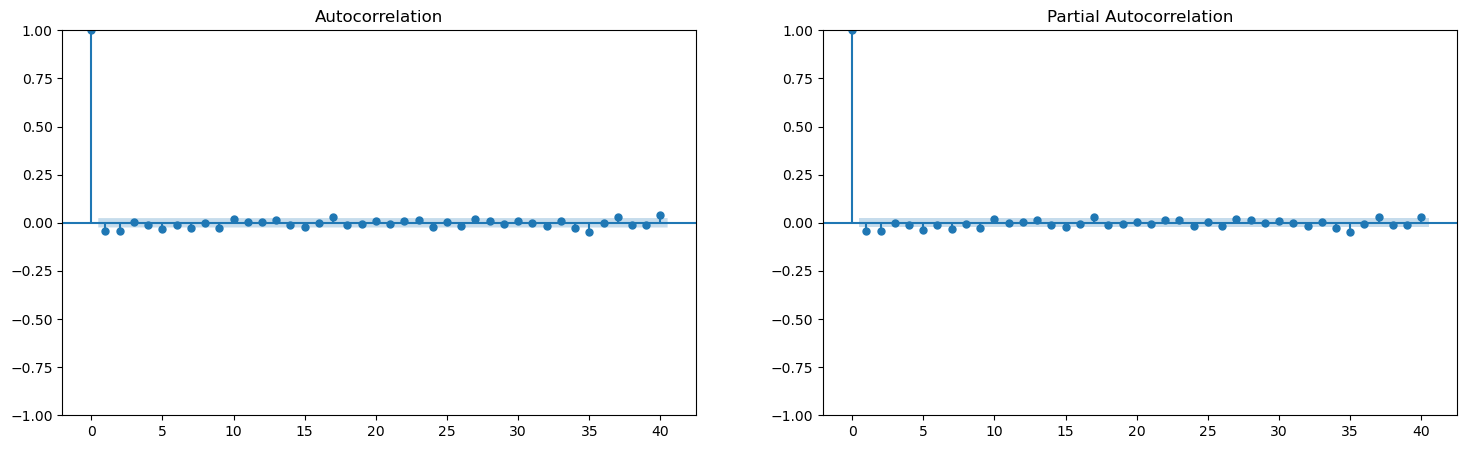

(-27.326250201731202,
 0.0,
 9,
 6507,
 {'1%': -3.4313553606207843,
  '5%': -2.8619842833301883,
  '10%': -2.56700648865667},
 52991.2781500849)

In [13]:
plot_acf_pacf(train_df["spx"].diff(1).dropna())
adfuller(train_df["spx"].diff(1).dropna())

Первые разности являются стационарными

## ARIMA, SARIMA

Начнем построение модели **ARIMA** со следующими параметрами:

- p = 1 
- d = 1 
- q = 1 

Если рассматривать сезонную модель (**SARMA**), то в модель можно добавить следующие параметры.

- m = 5 (будучи рыночным индексом, данные, скорее всего, будут иметь еженедельно повторяющиеся паттерны, как видно из визуализации)
- P = 1 
- D = 1
- Q = 1 

In [14]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df["spx"].dropna(), order = (1, 1, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 6518
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -26625.675
Date:                Mon, 14 Nov 2022   AIC                          53257.350
Time:                        18:58:44   BIC                          53277.697
Sample:                    01-06-1994   HQIC                         53264.387
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7598      0.048     15.908      0.000       0.666       0.853
ma.L1         -0.8016      0.044    -18.385      0.000      -0.887      -0.716
sigma2       207.1124      1.766    117.304      0.000     203.652     210.573
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             12081.79
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_df["spx"].dropna(), order = (1, 1, 1))
model_fit = model.fit()
model_fit.summary()

/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.08550D+00    |proj g|=  8.35412D-03

At iterate    5    f=  4.08539D+00    |proj g|=  5.96893D-03

At iterate   10    f=  4.08496D+00    |proj g|=  2.01707D-03

At iterate   15    f=  4.08495D+00    |proj g|=  7.97503D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     20      1     0     0   1.220D-06   4.085D+00
  F =   4.0849455671494912     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 6518
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -26625.675
Date:                Mon, 14 Nov 2022   AIC                          53257.350
Time:                        18:58:54   BIC                          53277.697
Sample:                    01-06-1994   HQIC                         53264.387
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7598      0.048     15.908      0.000       0.666       0.853
ma.L1         -0.8016      0.044    -18.385      0.000      -0.887      -0.716
sigma2       207.1124      1.766    117.304      0.000     203.652     210.573
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             12081.79
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Второй столбец раздела I содержит некоторые полезные показатели, которые используются для сравнения различных моделей ARIMA. Как правило, модель с более высоким логарифмическим правдоподобием или более низким IC (AIC, BIC или HQIC) лучше, и наоборот.

In [16]:
seas_model = SARIMAX(train_df["spx"].dropna(), order = (1, 1, 2), seasonal_order = (1, 1, 2, 5))
seas_model_fit = seas_model.fit()
seas_model_fit.summary()

/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18581D+00    |proj g|=  3.02895D-02

At iterate    5    f=  4.11432D+00    |proj g|=  3.10062D-02

At iterate   10    f=  4.08457D+00    |proj g|=  3.39039D-03

At iterate   15    f=  4.08455D+00    |proj g|=  2.23937D-04

At iterate   20    f=  4.08445D+00    |proj g|=  8.99982D-03

At iterate   25    f=  4.08419D+00    |proj g|=  2.82798D-03

At iterate   30    f=  4.08402D+00    |proj g|=  1.54856D-04

At iterate   35    f=  4.08400D+00    |proj g|=  1.80893D-03

At iterate   40    f=  4.08378D+00    |proj g|=  2.26316D-03

At iterate   45    f=  4.08374D+00    |proj g|=  2.64366D-04

At iterate   50    f=  4.08374D+00    |proj g|=  1.40348D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               spx   No. Observations:                 6518
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 5)   Log Likelihood              -26617.825
Date:                           Mon, 14 Nov 2022   AIC                          53249.649
Time:                                   18:59:46   BIC                          53297.119
Sample:                               01-06-1994   HQIC                         53266.066
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1712      0.167      1.024      0.306      -0.157       0.499
ma.L1         -0.2142      0.166     -1.286      0.198      -0.540       0.112
ma.L2         -0.0328      0.012     -2.845      0.004      -0.055      -0.010
ar.S.L5       -0.7762      0.080     -9.643      0.000      -0.934      -0.618
ma.S.L5       -0.2546      0.085     -3.008      0.003      -0.420      -0.089
ma.S.L10      -0.7448      0.085     -8.728      0.000      -0.912      -0.578
sigma2       206.9074      2.062    100.364      0.000     202.867     210.948
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11683.00
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
pred_df = pd.DataFrame(index = data.index)
pred_df["model_preds"] = seas_model_fit.predict(start = test_df.index[1], end = test_df.index[-1])


pred_df["spx"] = data["spx"]

forecast = seas_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower spx"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper spx"]

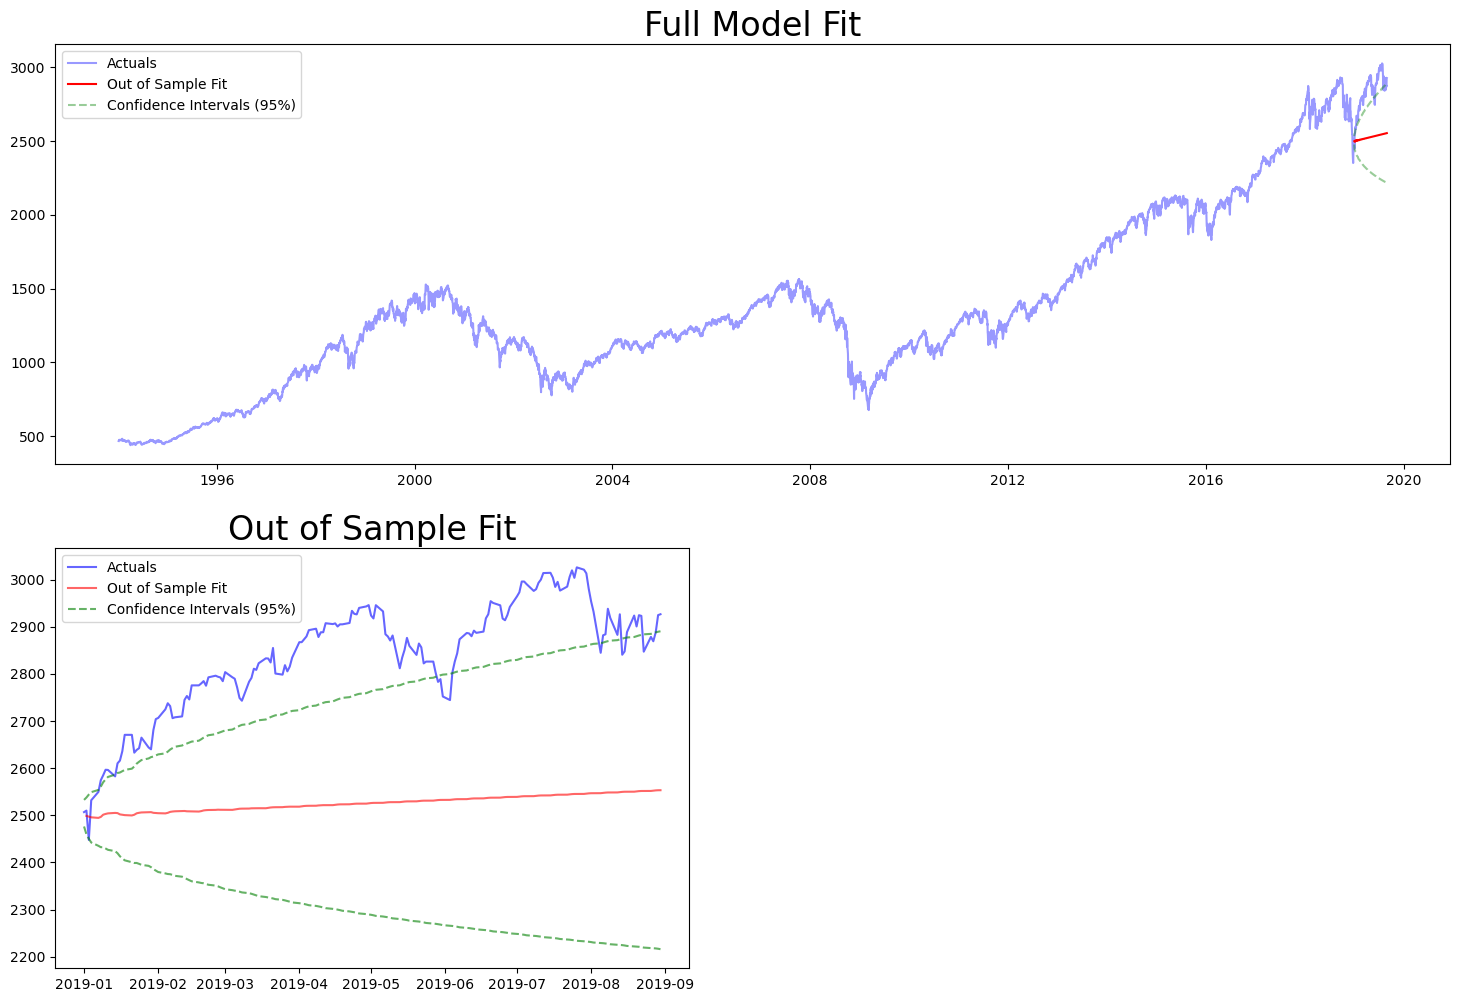

In [18]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["spx"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]["spx"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

In [19]:
# pip install pmdarima
import pmdarima as pm

smodel = pm.auto_arima(train_df, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=5,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=inf, Time=3.70 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=57943.325, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=55834.625, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=2.15 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=57939.123, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=55138.362, Time=0.84 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=10.44 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=3.11 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=55142.946, Time=0.57 sec
 ARIMA(2,1,0)(2,1,0)[5]             : AIC=55124.504, Time=1.25 sec
 ARIMA(2,1,0)(1,1,0)[5]             : AIC=55827.531, Time=0.73 sec
 ARIMA(2,1,0)(2,1,1)[5]             : AIC=inf, Time=16.90 sec
 ARIMA(2,1,0)(1,1,1)[5]             : AIC=inf, Time=5.73 sec
 ARIMA(3,1,0)(2,1,0)[5]             : AIC=55125.927, Time=1.34 sec
 ARIMA(2,1,1)(2,1,0)[5]             : AIC=55141.925, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 6518
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 5)   Log Likelihood              -27557.252
Date:                           Mon, 14 Nov 2022   AIC                          55124.504
Time:                                   19:01:47   BIC                          55158.411
Sample:                                        0   HQIC                         55136.230
                                          - 6518                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0335      0.008     -4.447      0.000      -0.048      -0.019
ar.L2         -0.0494      0.007     -7.204      0.000      -0.063      -0.036
ar.S.L5       -0.6999      0.007    -99.802      0.000      -0.714      -0.686
ar.S.L10      -0.3228      0.007    -43.233      0.000      -0.337      -0.308
sigma2       277.3268      2.423    114.438      0.000     272.577     282.077
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11066.86
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Downsampling / Upsampling / Интерполяция

In [20]:
print(data.shape)
data[(data.index>'2005-01-06') & (data.index<'2005-02-10')].head()

(6692, 1)


,spx
Date,
2005-01-07,1186.189941
2005-01-10,1190.250000
2005-01-11,1182.989990
2005-01-12,1187.699951
2005-01-13,1177.449951


<AxesSubplot:xlabel='Date'>

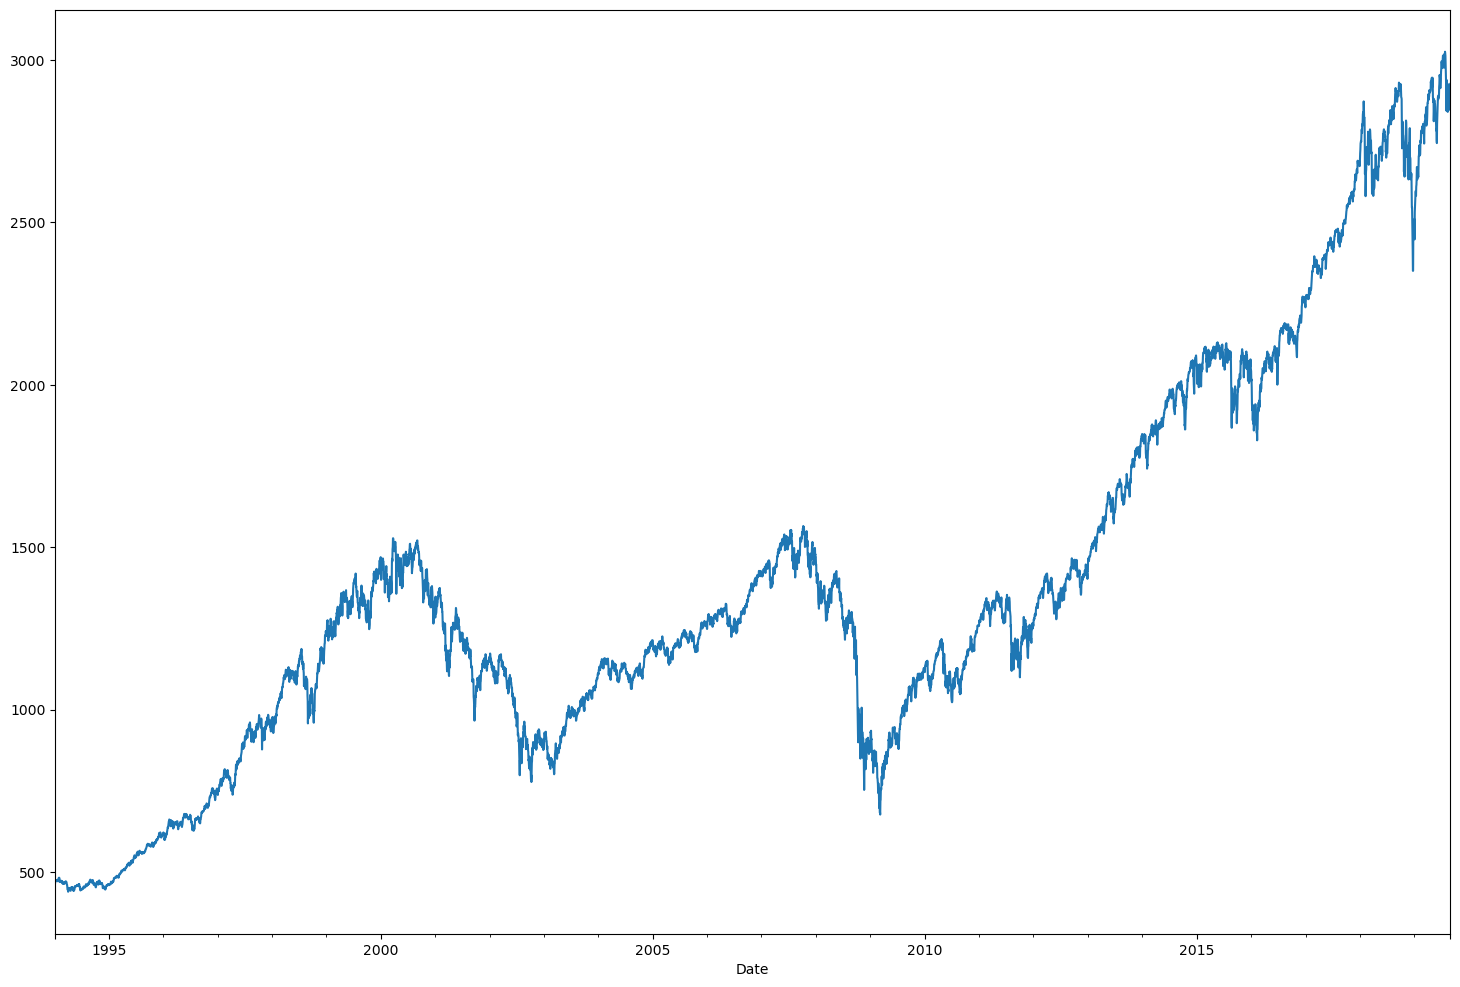

In [21]:
data.spx.plot()

(1339, 1)


<AxesSubplot:xlabel='Date'>

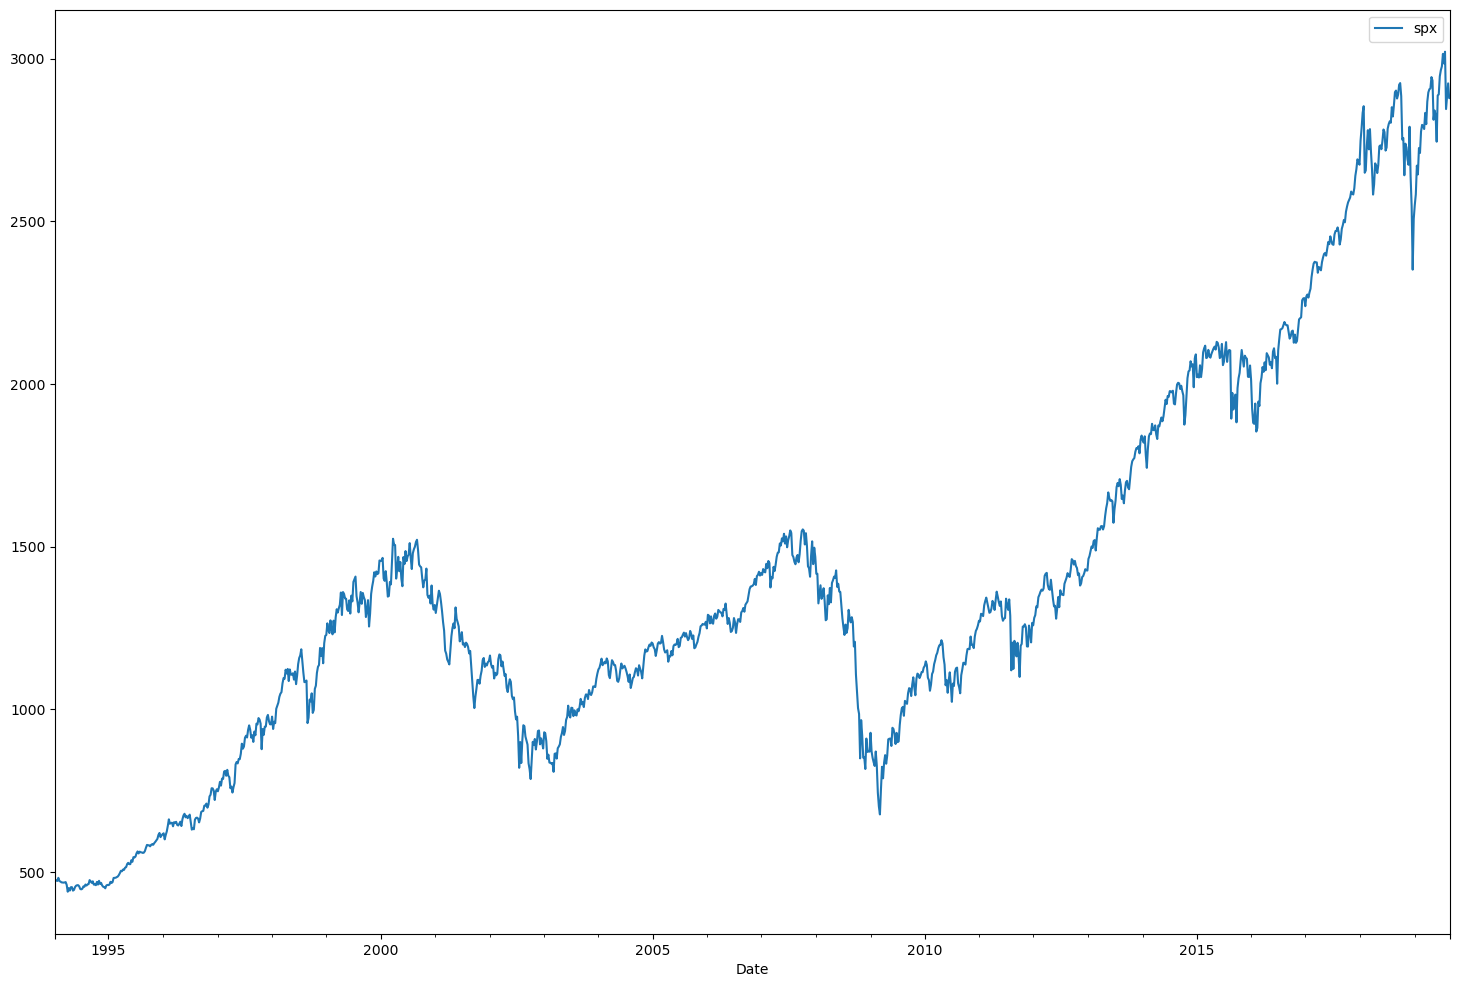

In [22]:
interpolated_data = pd.DataFrame(data.spx.resample('w-MON').interpolate(), columns = ["spx"])
print(interpolated_data.shape)
interpolated_data.plot()

In [23]:
interpolated_data.head()

,spx
Date,
1994-01-10,475.269989
1994-01-17,473.299988
1994-01-24,471.970001
1994-01-31,481.609985
1994-02-07,471.760010


In [24]:
train_df = interpolated_data.loc[:"2018-12-31"]
test_df = interpolated_data.loc["2019-01-01":]
train_df.shape, test_df.shape

((1304, 1), (35, 1))

/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


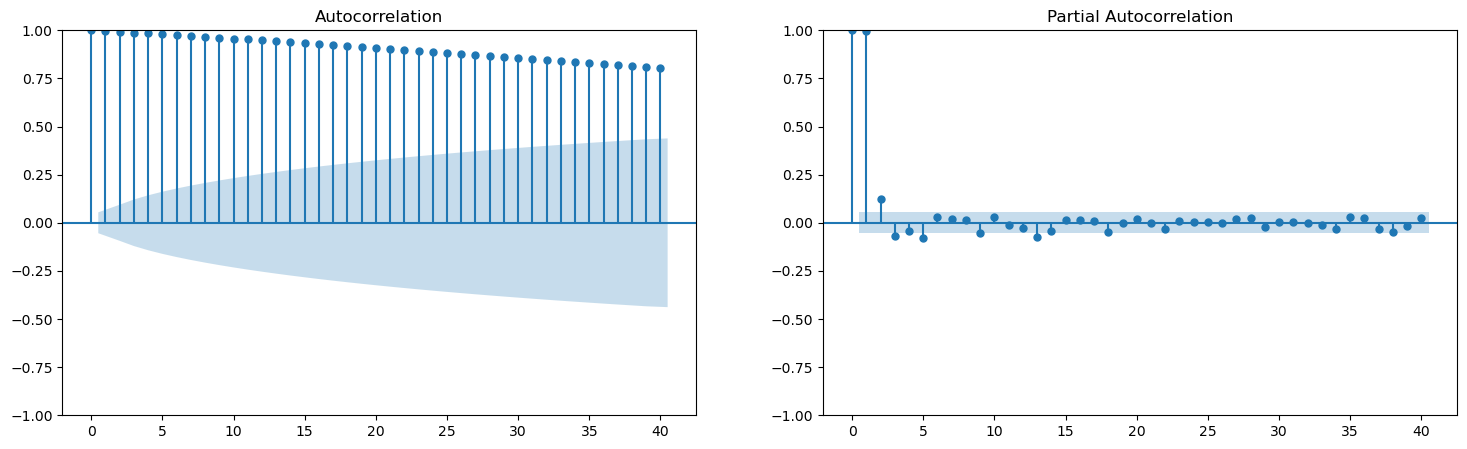

(-0.26076571431167217,
 0.9308801996019755,
 10,
 1293,
 {'1%': -3.4354175403897727,
  '5%': -2.8637778952086848,
  '10%': -2.5679614713589562},
 12512.497637173248)

In [25]:

plot_acf_pacf(train_df["spx"].dropna())
adfuller(train_df["spx"].dropna())

/home/sorcerer/.conda/envs/data-science/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


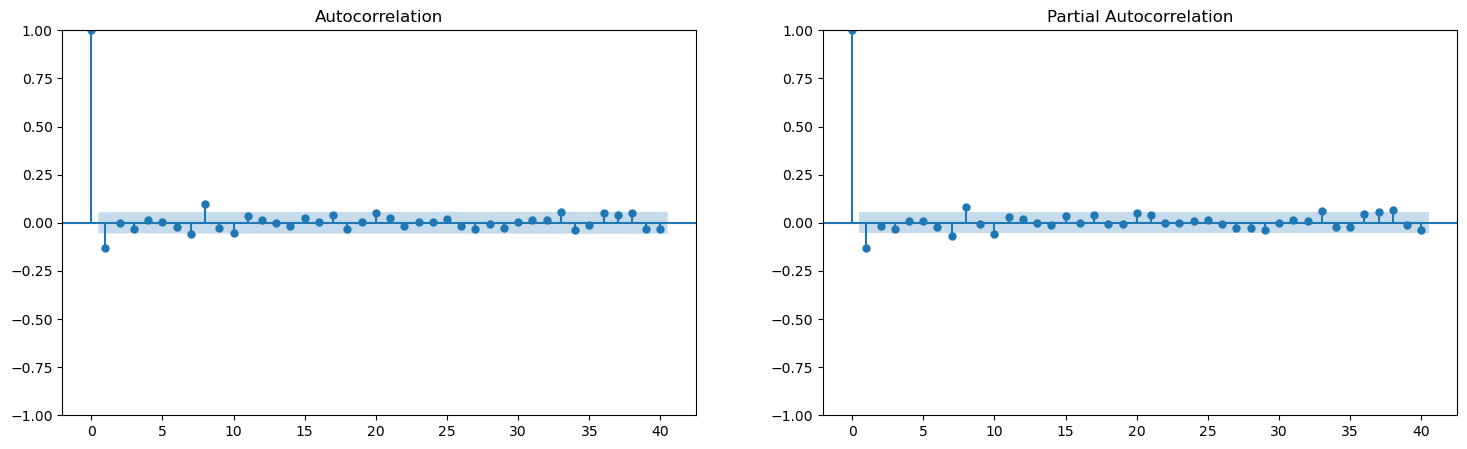

(-11.946377875600568,
 4.420358877553075e-22,
 9,
 1293,
 {'1%': -3.4354175403897727,
  '5%': -2.8637778952086848,
  '10%': -2.5679614713589562},
 12501.713967337682)

In [27]:
plot_acf_pacf(train_df["spx"].diff(1).dropna())
adfuller(train_df["spx"].diff(1).dropna())

In [28]:
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt

arima_model = ARIMA(train_df["spx"].dropna(), order = (1, 1, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 1304
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6359.035
Date:                Mon, 14 Nov 2022   AIC                          12724.070
Time:                        19:06:10   BIC                          12739.587
Sample:                    01-10-1994   HQIC                         12729.891
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0215      0.137      0.157      0.875      -0.247       0.290
ma.L1         -0.1545      0.132     -1.173      0.241      -0.413       0.104
sigma2      1015.0733     20.021     50.701      0.000     975.833    1054.314
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2373.55
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.31   Skew:                            -1.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
pred_df = pd.DataFrame(index = interpolated_data.index)
pred_df["model_preds"] = arima_model_fit.predict(start = test_df.index[1], end = test_df.index[-1])


pred_df["spx"] = interpolated_data["spx"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower spx"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper spx"]

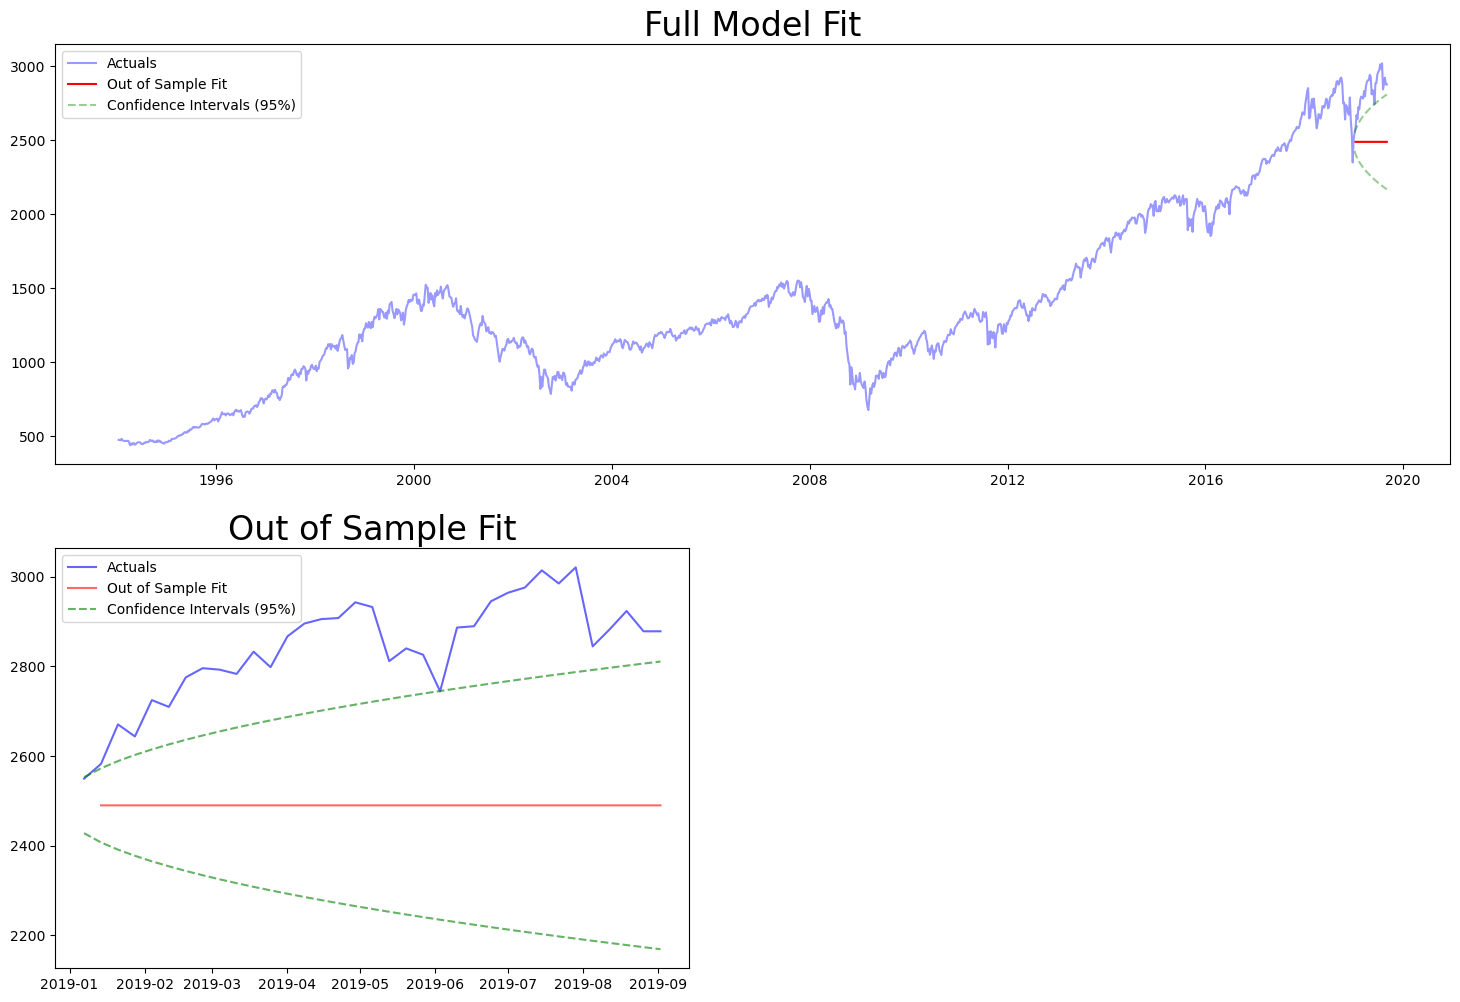

In [30]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["spx"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]["spx"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()